<a href="https://colab.research.google.com/github/Pooret/drug-discovery-ml/blob/main/Protein_ChemBert_Binding_Affinity_Prediction_for_Small_Molecules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Dataset](https://www.kaggle.com/competitions/leash-BELKA/data)

In [1]:
!pip install pandas pyarrow
!pip install duckdb
!pip install rdkit
!pip install py3Dmol
!pip install mordred
!pip install deepchem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.4 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176720 sha256=37c7531a5f20bd53beb910848b1ee205a7f20579d25430c58bcef457691fbd34
  Stored in directory: /root/.cache/pip/wheels/a7/4f/b8/d4c6591f6ac944aaced7865b349477695f662388ad958743c7
Successfully built mordred
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
      Successfully uninstalled networkx-3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_mach

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import os

# Create directory path for data
directory_path = "/content/data"

# Check if the directory already exists
if not os.path.exists(directory_path):
    os.mkdir(directory_path)
    print(f"Directory created at {directory_path}")
else:
    print(f"Directory already exists at {directory_path}")

Directory created at /content/data


In [4]:
%%time
!unzip /content/drive/MyDrive/Datasets/leash_BELKA/data.zip -d /content/data

Archive:  /content/drive/MyDrive/Datasets/leash_BELKA/data.zip
  inflating: /content/data/sample_submission.csv  
  inflating: /content/data/test.csv  
  inflating: /content/data/test.parquet  
  inflating: /content/data/train.csv  
  inflating: /content/data/train.parquet  
CPU times: user 1.67 s, sys: 179 ms, total: 1.85 s
Wall time: 5min 28s


In [54]:
%%time
#By Andrew D. Blevins https://www.kaggle.com/code/andrewdblevins/leash-tutorial-ecfps-and-random-forest

import duckdb
import pandas as pd

train_path = '/content/data/train.parquet'
test_path = '/content/data/test.parquet'

con = duckdb.connect()

max_limit = 1589906
limit_num = 30000

# 1589906 is the total number of binding samples
df = con.query(f"""(SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 0
                        ORDER BY random()
                        LIMIT {limit_num})
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 1
                        ORDER BY random()
                        LIMIT {limit_num})""").df()

con.close()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 2min 32s, sys: 9.18 s, total: 2min 41s
Wall time: 33 s


In [55]:
df.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,84259618,O=C(NCc1cccc(C(=O)O)c1)OCC1c2ccccc2-c2ccccc21,Cc1cc(N)ncn1,Nc1cc(-c2ccccc2)[nH]n1,Cc1cc(Nc2nc(NCc3cccc(C(=O)N[Dy])c3)nc(Nc3cc(-c...,HSA,0
1,155313688,O=C(Nc1c(OC(F)(F)F)cccc1C(=O)O)OCC1c2ccccc2-c2...,Cl.NCCNC(=O)c1ccc(Cl)cc1,Nc1cccc(N2CCCC2)c1,O=C(NCCNc1nc(Nc2cccc(N3CCCC3)c2)nc(Nc2c(OC(F)(...,HSA,0
2,170470527,O=C(Nc1cc(Cl)nc(C(=O)O)c1Cl)OCC1c2ccccc2-c2ccc...,Cl.Cl.NCc1nc(-c2ccncc2)no1,Nc1cc(Br)cn2ccnc12,O=C(N[Dy])c1nc(Cl)cc(Nc2nc(NCc3nc(-c4ccncc4)no...,BRD4,0
3,188457389,O=C(Nc1ccc(C(=O)O)cc1)OCC1c2ccccc2-c2ccccc21,Nc1nccc(Cl)n1,CC(CN)S(C)=O,CC(CNc1nc(Nc2ccc(C(=O)N[Dy])cc2)nc(Nc2nccc(Cl)...,sEH,0
4,274351051,O=C(O)C[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)c1cc...,Nc1ccc(Cl)c(F)c1,Cc1cc(CN)c(C)[nH]1,Cc1cc(CNc2nc(Nc3ccc(Cl)c(F)c3)nc(N[C@@H](CC(=O...,HSA,0


In [56]:
df.shape

(60000, 7)

<Axes: xlabel='protein_name'>

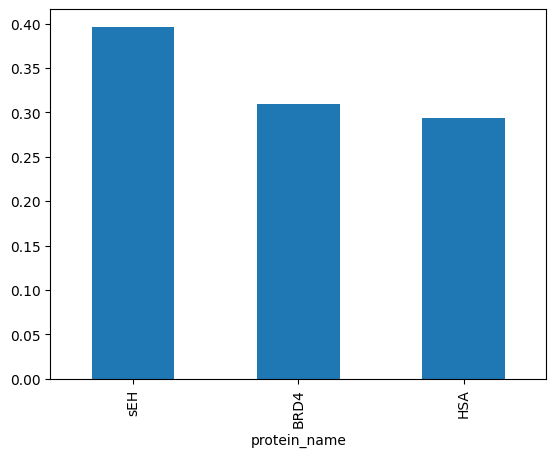

In [57]:
df['protein_name'].value_counts(normalize=True).plot(kind='bar')

### Targets

**EPHX2 (sEH)**

The first target, epoxide hydrolase 2, is encoded by the EPHX2 genetic locus, and its protein product is commonly named “soluble epoxide hydrolase”, or abbreviated to sEH. Hydrolases are enzymes that catalyze certain chemical reactions, and EPHX2/sEH also hydrolyzes certain phosphate groups. EPHX2/sEH is a potential drug target for high blood pressure and diabetes progression, and small molecules inhibiting EPHX2/sEH from earlier DEL efforts made it to clinical trials.

EPHX2/sEH was also screened with DELs, and hits predicted with ML approaches, in a recent study but the screening data were not published. We included EPHX2/sEH to allow contestants an external gut check for model performance by comparing to these previously-published results.

We screened EPHX2/sEH purchased from Cayman Chemical, a life sciences commercial vendor. For those contestants wishing to incorporate protein structural information in their submissions, the amino sequence is positions 2-555 from UniProt entry [P34913](https://www.uniprot.org/uniprotkb/P34913/entry#sequences), the crystal structure can be found in PDB entry [3i28](https://www.rcsb.org/structure/3i28), and predicted structure can be found in AlphaFold2 entry [34913](https://alphafold.ebi.ac.uk/entry/P34913). Additional EPHX2/sEH crystal structures with ligands bound can be found in PDB.

In [58]:
# import py3Dmol
# view = py3Dmol.view(query='pdb:3i38')
# view.setStyle({"cartoon":{"color":"white"}})
# view.setBackgroundColor("black")
# view.show()

**BRD4**

The second target, bromodomain 4, is encoded by the BRD4 locus and its protein product is also named BRD4. Bromodomains bind to protein spools in the nucleus that DNA wraps around (called histones) and affect the likelihood that the DNA nearby is going to be transcribed, producing new gene products. Bromodomains play roles in cancer progression and a number of drugs have been discovered to inhibit their activities.

BRD4 has been screened with DEL approaches previously but the screening data were not published. We included BRD4 to allow contestants to evaluate candidate molecules for oncology indications.

We screened BRD4 purchased from Active Motif, a life sciences commercial vendor. For those contestants wishing to incorporate protein structural information in their submissions, the amino acid sequence is positions 44-460 from UniProt entry [O60885-1](https://www.uniprot.org/uniprotkb/O60885/entry#sequences), the crystal structure (for a single domain) can be found in PDB entry [7USK](https://www.rcsb.org/structure/7USK) and predicted structure can be found in AlphaFold2 entry [O60885](https://alphafold.ebi.ac.uk/entry/O60885
). Additional BRD4 crystal structures with ligands bound can be found in PDB.

In [59]:
# view = py3Dmol.view(query='pdb:7usk')
# view.setStyle({"cartoon":{"color":"white"}})
# view.setBackgroundColor("black")
# view.show()

**ALB (HSA)**


The third target, serum albumin, is encoded by the ALB locus and its protein product is also named ALB. The protein product is sometimes abbreviated as HSA, for “human serum albumin”. ALB, the most common protein in the blood, is used to drive osmotic pressure (to bring fluid back from tissues into blood vessels) and to transport many ligands, hormones, fatty acids, and more.

Albumin, being the most abundant protein in the blood, often plays a role in absorbing candidate drugs in the body and sequestering them from their target tissues. Adjusting candidate drugs to bind less to albumin and other blood proteins is a strategy to help these candidate drugs be more effective.

ALB has been screened with DEL approaches previously but the screening data were not published. We included ALB to allow contestants to build models that might have a larger impact on drug discovery across many disease types. The ability to predict ALB binding well would allow drug developers to improve their candidate small molecule therapies much more quickly than physically manufacturing many variants and testing them against ALB empirically in an iterative process.

We screened ALB purchased from Active Motif. For those contestants wishing to incorporate protein structural information in their submissions, the amino acid sequence is positions 25 to 609 from UniProt entry [P02768](https://www.uniprot.org/uniprotkb/P02768/entry#sequences), the crystal structure can be found in PDB entry [1AO6](https://www.ebi.ac.uk/pdbe/entry/pdb/1AO6), and predicted structure can be found in AlphaFold2 entry [P02768](https://alphafold.ebi.ac.uk/entry/P02768). Additional ALB crystal structures with ligands bound can be found in PDB.



In [60]:
# view = py3Dmol.view(query='pdb:1ao6')
# view.setStyle({"cartoon":{"color":"white"}})
# view.setBackgroundColor("black")
# view.show()

In [61]:
df['binds'].value_counts()

binds
0    30000
1    30000
Name: count, dtype: int64

In [62]:
df['buildingblock1_smiles'].value_counts()

buildingblock1_smiles
O=C(NCC1CCC(C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21               4993
O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21       3278
CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O                  740
CC(OC(C)(C)C)C(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O           734
O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21               696
                                                            ... 
O=C(Nc1ccc([N+](=O)[O-])cc1C(=O)O)OCC1c2ccccc2-c2ccccc21     103
O=C(Nc1c(Cl)c(Cl)nc(C(=O)O)c1Cl)OCC1c2ccccc2-c2ccccc21       102
C=CCC(CC=C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O              101
O=C(Nc1nc(Cl)ccc1C(=O)O)OCC1c2ccccc2-c2ccccc21                99
O=C(Nc1cc(Cl)nc(C(=O)O)c1Cl)OCC1c2ccccc2-c2ccccc21            81
Name: count, Length: 271, dtype: int64

In [63]:
df['molecule_smiles'].value_counts()

molecule_smiles
Cc1ccc(Nc2nc(Nc3cncc(F)c3)nc(Nc3n[nH]cc3C#N)n2)c(C(=O)N[Dy])c1                          2
Cc1ccc(C(=O)N[Dy])cc1Nc1nc(Nc2cncc(F)c2)nc(Nc2[nH]cnc2C#N)n1                            2
COc1cccc(-c2cc(Nc3nc(NCc4cncc(F)c4)nc(Nc4c(C)cc(C)cc4C(=O)N[Dy])n3)on2)c1               2
CN(Cc1ccco1)Cc1ccccc1CNc1nc(NC[C@H]2CC[C@H](C(=O)N[Dy])CC2)nc(Nc2cc(Cl)ccc2F)n1         2
CCC(C)C(Nc1nc(NCc2cnc(F)cc2C)nc(Nc2ccc(F)c(C(F)(F)F)c2)n1)C(=O)N[Dy]                    2
                                                                                       ..
NC(=O)C(F)(F)CNc1nc(NCc2ccsc2)nc(Nc2ccc(C(=O)N[Dy])cc2OC(F)(F)F)n1                      1
O=C(N[Dy])[C@H](Cc1ccc(C(F)(F)F)cc1)Nc1nc(NCc2noc3c2COCC3)nc(Nc2nc(Cl)cc(Cl)n2)n1       1
Cc1cc(=O)oc2cc(Nc3nc(NCC4CC(=O)N(C)C4)nc(NC(CC(C)C)C(=O)N[Dy])n3)ccc12                  1
Cc1cc(O)cc(C)c1Nc1nc(Nc2ncc([N+](=O)[O-])s2)nc(Nc2c(Cl)cc(F)cc2C(=O)N[Dy])n1            1
COC(=O)c1ccc(Nc2nc(Nc3cc(C(C)(C)C)[nH]n3)nc(N[C@H](CC(=O)N[Dy])c3ccc(Cl)cc3)n2)cc1OC

In [64]:
df[df['binds'] == 1]['buildingblock1_smiles'].value_counts()

buildingblock1_smiles
O=C(NCC1CCC(C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21             4895
O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21     3182
CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O                646
CC(OC(C)(C)C)C(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O         632
O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21             585
                                                          ... 
O=C(Nc1ncc(Br)nc1C(=O)O)OCC1c2ccccc2-c2ccccc21               2
O=C(Nc1cc(Cl)ncc1C(=O)O)OCC1c2ccccc2-c2ccccc21               1
O=C(Nc1c(Br)cc(C(=O)O)cc1Br)OCC1c2ccccc2-c2ccccc21           1
O=C(Nc1cc(Cl)nc(C(=O)O)c1Cl)OCC1c2ccccc2-c2ccccc21           1
O=C(Nc1c(Cl)c(Cl)nc(C(=O)O)c1Cl)OCC1c2ccccc2-c2ccccc21       1
Name: count, Length: 266, dtype: int64

In [65]:
df.isna().sum()

id                       0
buildingblock1_smiles    0
buildingblock2_smiles    0
buildingblock3_smiles    0
molecule_smiles          0
protein_name             0
binds                    0
dtype: int64

<Axes: xlabel='protein_name'>

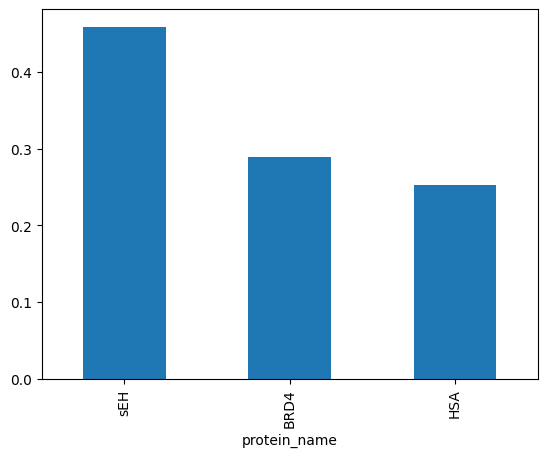

In [66]:
df[df['binds'] == 1]['protein_name'].value_counts(normalize=True).plot(kind='bar')

In [67]:
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit import DataStructs
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors import CalcMolDescriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from mordred import Calculator, descriptors

In [68]:
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit import RDLogger

# Suppress RDKit warnings and info messages
RDLogger.DisableLog('rdApp.*')

# Create canonical smiles to check for duplicates
def canonical_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return Chem.MolToSmiles(mol)
    else:
        return False

def process_dataframe(df):
    canonical_smiles_list = []
    for smiles in tqdm(df['molecule_smiles'], desc="Processing DataFrame"):
        canonical_smiles_list.append(canonical_smiles(smiles))
    df['canonical_smiles'] = canonical_smiles_list
    return df

# Process the DataFrame
df = process_dataframe(df)
df.head()

Processing DataFrame:   0%|          | 0/60000 [00:00<?, ?it/s]

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds,canonical_smiles
0,84259618,O=C(NCc1cccc(C(=O)O)c1)OCC1c2ccccc2-c2ccccc21,Cc1cc(N)ncn1,Nc1cc(-c2ccccc2)[nH]n1,Cc1cc(Nc2nc(NCc3cccc(C(=O)N[Dy])c3)nc(Nc3cc(-c...,HSA,0,Cc1cc(Nc2nc(NCc3cccc(C(=O)N[Dy])c3)nc(Nc3cc(-c...
1,155313688,O=C(Nc1c(OC(F)(F)F)cccc1C(=O)O)OCC1c2ccccc2-c2...,Cl.NCCNC(=O)c1ccc(Cl)cc1,Nc1cccc(N2CCCC2)c1,O=C(NCCNc1nc(Nc2cccc(N3CCCC3)c2)nc(Nc2c(OC(F)(...,HSA,0,O=C(NCCNc1nc(Nc2cccc(N3CCCC3)c2)nc(Nc2c(OC(F)(...
2,170470527,O=C(Nc1cc(Cl)nc(C(=O)O)c1Cl)OCC1c2ccccc2-c2ccc...,Cl.Cl.NCc1nc(-c2ccncc2)no1,Nc1cc(Br)cn2ccnc12,O=C(N[Dy])c1nc(Cl)cc(Nc2nc(NCc3nc(-c4ccncc4)no...,BRD4,0,O=C(N[Dy])c1nc(Cl)cc(Nc2nc(NCc3nc(-c4ccncc4)no...
3,188457389,O=C(Nc1ccc(C(=O)O)cc1)OCC1c2ccccc2-c2ccccc21,Nc1nccc(Cl)n1,CC(CN)S(C)=O,CC(CNc1nc(Nc2ccc(C(=O)N[Dy])cc2)nc(Nc2nccc(Cl)...,sEH,0,CC(CNc1nc(Nc2ccc(C(=O)N[Dy])cc2)nc(Nc2nccc(Cl)...
4,274351051,O=C(O)C[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)c1cc...,Nc1ccc(Cl)c(F)c1,Cc1cc(CN)c(C)[nH]1,Cc1cc(CNc2nc(Nc3ccc(Cl)c(F)c3)nc(N[C@@H](CC(=O...,HSA,0,Cc1cc(CNc2nc(Nc3ccc(Cl)c(F)c3)nc(N[C@@H](CC(=O...


In [69]:
df = df.drop_duplicates(subset=['canonical_smiles','protein_name'], keep='first')

<Axes: >

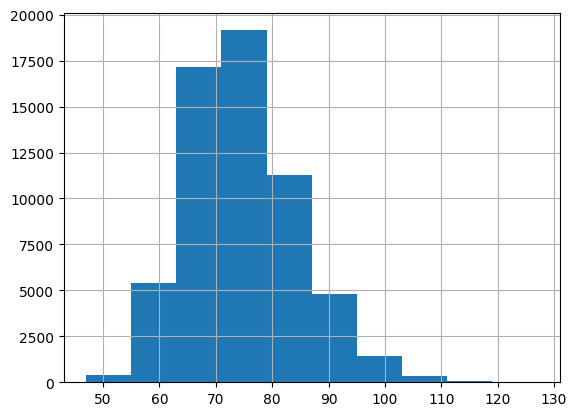

In [70]:
df['canonical_smiles_len'] = df['canonical_smiles'].apply(len)
df['canonical_smiles_len'].hist()

In [74]:

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from tqdm import tqdm
import os

# Hyperparameters
epochs = 30
batch_size = 256
learning_rate = 1e-4

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
model = AutoModelForSequenceClassification.from_pretrained("DeepChem/ChemBERTa-77M-MTR", num_labels=2).to(device)

# Add new tokens to tokenizer
new_tokens = ['HSA', 'sEH', 'BRD4']
tokenizer.add_tokens(new_tokens)
model.resize_token_embeddings(len(tokenizer))

model_save_dir = "/content/drive/MyDrive/models/chembert_BELKA"

os.makedirs(model_save_dir, exist_ok=True)

model_save_path = os.path.join(model_save_dir, 'protein_best_model.pth')

# Define a custom dataset class
class SMILESDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        smiles = self.dataframe.iloc[idx]['canonical_smiles']
        protein = self.dataframe.iloc[idx]['protein_name']
        text = f"{smiles} {protein}"
        label = self.dataframe.iloc[idx]['binds']
        return text, label

    def collate_fn(self, batch):
        # Tokenize and convert to tensors
        tokenized_batch = [self.tokenizer.encode(smiles, add_special_tokens=True) for smiles, _ in batch]
        padded_batch = pad_sequence([torch.tensor(tokens) for tokens in tokenized_batch],
                                    batch_first=True, padding_value=self.tokenizer.pad_token_id)

        labels = torch.tensor([label for _, label in batch], dtype=torch.long)

        return padded_batch, labels

# Split the data into training and validation sets
train_df, test_df = train_test_split(df, test_size=0.2)

# Create datasets and data loaders
train_dataset = SMILESDataset(train_df, tokenizer)
val_dataset = SMILESDataset(test_df, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=val_dataset.collate_fn)

# Define the optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=1, verbose=True)
loss_fn = torch.nn.CrossEntropyLoss()

# Training and validation loop

train_losses = []
val_losses = []
train_acc = []
val_acc = []

best_epoch = 0
best_val_loss = float('inf')
best_val_acc = 0

for epoch in tqdm(range(epochs)):

    train_loss = 0
    train_correct = 0
    train_count = 0

    model.train()
    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)
        attention_mask = (inputs != tokenizer.pad_token_id).type(torch.long).to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=inputs, attention_mask=attention_mask)
        logits = outputs.logits  # Shape: [batch_size, num_labels]

        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        train_correct += (preds == labels).sum().item()
        train_count += labels.size(0)

    avg_train_loss = train_loss / train_count
    train_losses.append(avg_train_loss)
    train_accuracy = train_correct / train_count
    train_acc.append(train_accuracy)

    # Evaluation loop
    val_loss = 0
    val_correct = 0
    val_count = 0
    true_labels = []
    pred_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            attention_mask = (inputs != tokenizer.pad_token_id).type(torch.long).to(device)

            outputs = model(input_ids=inputs, attention_mask=attention_mask)
            logits = outputs.logits  # Shape: [batch_size, num_labels]

            loss = loss_fn(logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_count += labels.size(0)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    avg_val_loss = val_loss / val_count
    val_losses.append(avg_val_loss)
    val_accuracy = val_correct / val_count
    val_acc.append(val_accuracy)

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      best_epoch = epoch
      best_val_acc = val_accuracy
      torch.save(model.state_dict(), model_save_path)

    scheduler.step(avg_val_loss)

    print(f'Epoch: {epoch + 1}/{epochs}')
    print(f'Train Loss: {avg_train_loss:.4f}')
    print(f'Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {avg_val_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f}')


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  3%|▎         | 1/30 [00:57<27:37, 57.15s/it]

Epoch: 1/30
Train Loss: 0.0020
Train Accuracy: 0.7257
Validation Loss: 0.0016
Validation Accuracy: 0.8267


  7%|▋         | 2/30 [01:54<26:36, 57.02s/it]

Epoch: 2/30
Train Loss: 0.0016
Train Accuracy: 0.8240
Validation Loss: 0.0014
Validation Accuracy: 0.8474


 10%|█         | 3/30 [02:51<25:40, 57.06s/it]

Epoch: 3/30
Train Loss: 0.0015
Train Accuracy: 0.8412
Validation Loss: 0.0013
Validation Accuracy: 0.8597


 13%|█▎        | 4/30 [03:47<24:35, 56.74s/it]

Epoch: 4/30
Train Loss: 0.0014
Train Accuracy: 0.8527
Validation Loss: 0.0013
Validation Accuracy: 0.8622


 17%|█▋        | 5/30 [04:43<23:35, 56.64s/it]

Epoch: 5/30
Train Loss: 0.0013
Train Accuracy: 0.8576
Validation Loss: 0.0013
Validation Accuracy: 0.8675


 20%|██        | 6/30 [05:40<22:38, 56.62s/it]

Epoch: 6/30
Train Loss: 0.0013
Train Accuracy: 0.8644
Validation Loss: 0.0013
Validation Accuracy: 0.8692


 23%|██▎       | 7/30 [06:36<21:39, 56.52s/it]

Epoch: 7/30
Train Loss: 0.0013
Train Accuracy: 0.8699
Validation Loss: 0.0012
Validation Accuracy: 0.8732


 27%|██▋       | 8/30 [07:33<20:44, 56.59s/it]

Epoch: 8/30
Train Loss: 0.0012
Train Accuracy: 0.8719
Validation Loss: 0.0012
Validation Accuracy: 0.8739


 30%|███       | 9/30 [08:30<19:49, 56.65s/it]

Epoch: 9/30
Train Loss: 0.0012
Train Accuracy: 0.8732
Validation Loss: 0.0012
Validation Accuracy: 0.8761


 33%|███▎      | 10/30 [09:27<18:53, 56.70s/it]

Epoch: 10/30
Train Loss: 0.0012
Train Accuracy: 0.8757
Validation Loss: 0.0012
Validation Accuracy: 0.8798


 37%|███▋      | 11/30 [10:23<17:56, 56.67s/it]

Epoch: 11/30
Train Loss: 0.0011
Train Accuracy: 0.8796
Validation Loss: 0.0012
Validation Accuracy: 0.8806


 40%|████      | 12/30 [11:20<17:01, 56.72s/it]

Epoch: 12/30
Train Loss: 0.0011
Train Accuracy: 0.8842
Validation Loss: 0.0011
Validation Accuracy: 0.8849


 43%|████▎     | 13/30 [12:17<16:06, 56.87s/it]

Epoch: 13/30
Train Loss: 0.0011
Train Accuracy: 0.8885
Validation Loss: 0.0011
Validation Accuracy: 0.8880


 47%|████▋     | 14/30 [13:14<15:08, 56.77s/it]

Epoch: 14/30
Train Loss: 0.0010
Train Accuracy: 0.8910
Validation Loss: 0.0011
Validation Accuracy: 0.8887


 50%|█████     | 15/30 [14:10<14:08, 56.55s/it]

Epoch: 15/30
Train Loss: 0.0010
Train Accuracy: 0.8943
Validation Loss: 0.0010
Validation Accuracy: 0.8928


 53%|█████▎    | 16/30 [15:07<13:12, 56.62s/it]

Epoch: 16/30
Train Loss: 0.0010
Train Accuracy: 0.8981
Validation Loss: 0.0010
Validation Accuracy: 0.8940


 57%|█████▋    | 17/30 [16:03<12:17, 56.69s/it]

Epoch: 17/30
Train Loss: 0.0009
Train Accuracy: 0.9015
Validation Loss: 0.0010
Validation Accuracy: 0.8940


 60%|██████    | 18/30 [17:01<11:21, 56.79s/it]

Epoch: 18/30
Train Loss: 0.0009
Train Accuracy: 0.9022
Validation Loss: 0.0010
Validation Accuracy: 0.8984


 63%|██████▎   | 19/30 [17:58<10:25, 56.88s/it]

Epoch: 19/30
Train Loss: 0.0009
Train Accuracy: 0.9053
Validation Loss: 0.0010
Validation Accuracy: 0.8982


 67%|██████▋   | 20/30 [18:55<09:30, 57.00s/it]

Epoch: 20/30
Train Loss: 0.0009
Train Accuracy: 0.9084
Validation Loss: 0.0010
Validation Accuracy: 0.8995


 70%|███████   | 21/30 [19:52<08:33, 57.08s/it]

Epoch: 21/30
Train Loss: 0.0009
Train Accuracy: 0.9104
Validation Loss: 0.0010
Validation Accuracy: 0.9018


 73%|███████▎  | 22/30 [20:49<07:34, 56.86s/it]

Epoch: 22/30
Train Loss: 0.0008
Train Accuracy: 0.9133
Validation Loss: 0.0010
Validation Accuracy: 0.9017


 77%|███████▋  | 23/30 [21:45<06:37, 56.76s/it]

Epoch: 23/30
Train Loss: 0.0008
Train Accuracy: 0.9126
Validation Loss: 0.0010
Validation Accuracy: 0.8982


 80%|████████  | 24/30 [22:41<05:38, 56.46s/it]

Epoch: 24/30
Train Loss: 0.0008
Train Accuracy: 0.9158
Validation Loss: 0.0010
Validation Accuracy: 0.8957


 83%|████████▎ | 25/30 [23:37<04:42, 56.44s/it]

Epoch: 25/30
Train Loss: 0.0008
Train Accuracy: 0.9160
Validation Loss: 0.0010
Validation Accuracy: 0.8997


 87%|████████▋ | 26/30 [24:34<03:45, 56.44s/it]

Epoch: 26/30
Train Loss: 0.0008
Train Accuracy: 0.9174
Validation Loss: 0.0010
Validation Accuracy: 0.8975


 90%|█████████ | 27/30 [25:31<02:50, 56.71s/it]

Epoch: 27/30
Train Loss: 0.0008
Train Accuracy: 0.9201
Validation Loss: 0.0010
Validation Accuracy: 0.9002


 93%|█████████▎| 28/30 [26:28<01:53, 56.77s/it]

Epoch: 28/30
Train Loss: 0.0008
Train Accuracy: 0.9207
Validation Loss: 0.0010
Validation Accuracy: 0.8992


 97%|█████████▋| 29/30 [27:24<00:56, 56.68s/it]

Epoch: 29/30
Train Loss: 0.0007
Train Accuracy: 0.9223
Validation Loss: 0.0010
Validation Accuracy: 0.8977


100%|██████████| 30/30 [28:22<00:00, 56.74s/it]

Epoch: 30/30
Train Loss: 0.0007
Train Accuracy: 0.9226
Validation Loss: 0.0010
Validation Accuracy: 0.9011


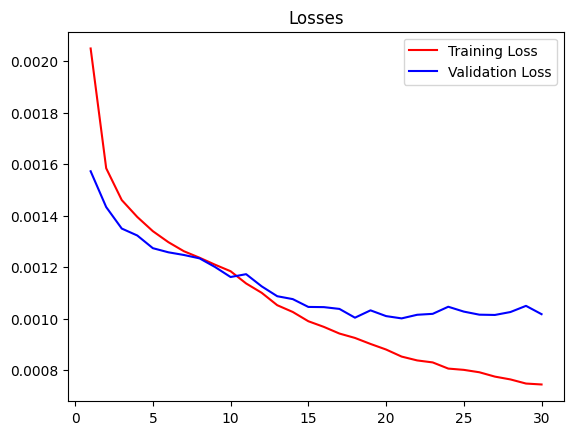

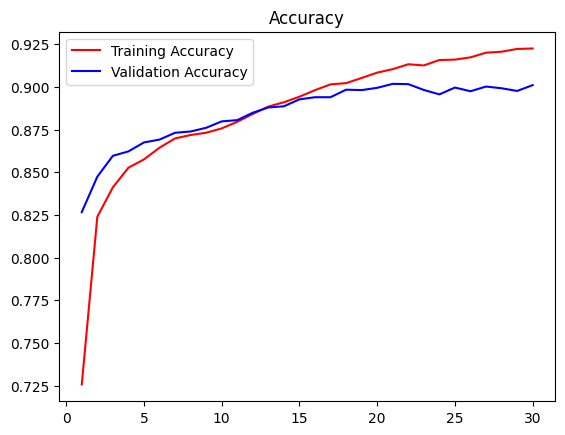

In [75]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(1, epochs+1), train_losses, c='r',label='Training Loss')
plt.plot(np.arange(1, epochs+1), val_losses, c='b', label='Validation Loss')
plt.legend()
plt.title("Losses")
plt.show()

plt.plot(np.arange(1, epochs+1), train_acc, c='r',label='Training Accuracy')
plt.plot(np.arange(1, epochs+1), val_acc, c='b', label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()

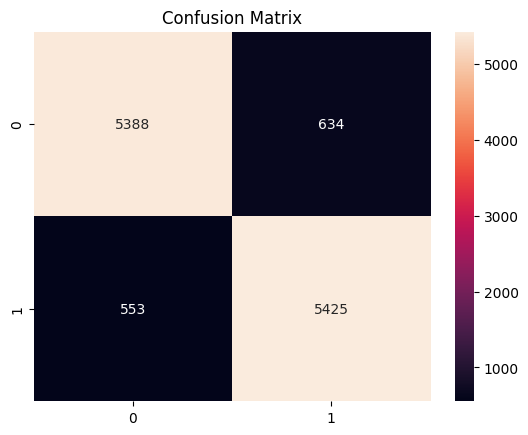

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      6022
           1       0.90      0.91      0.90      5978

    accuracy                           0.90     12000
   macro avg       0.90      0.90      0.90     12000
weighted avg       0.90      0.90      0.90     12000



In [77]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
conf_matrix = confusion_matrix(true_labels, pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(true_labels, pred_labels))

In [78]:
from datetime import datetime
model.load_state_dict(torch.load(model_save_path))
current_date = datetime.now().strftime("%Y%m%d_%H")
model_filename = f"proteinmodel_{best_val_acc:.4f}acc_{best_val_loss:.4f}loss_{epochs}epochs_{learning_rate}lr_{batch_size}batch_{current_date}.pth"
new_model_save_path = os.path.join(model_save_dir, model_filename)
torch.save(model.state_dict(), new_model_save_path)

In [10]:

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
model = AutoModelForSequenceClassification.from_pretrained("DeepChem/ChemBERTa-77M-MTR", num_labels=2)
model_save_path = "/content/drive/MyDrive/models/chembert_BELKA/proteinmodel_0.9356acc_0.0003loss_30epochs_0.0002lr_512batch_20240523_00.pth"
model.load_state_dict(torch.load(model_save_path))
model.eval()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(600, 384, padding_idx=1)
      (position_embeddings): Embedding(515, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.144, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-2): 3 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.109, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
             

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model.eval()

binding = df[df['binds'] == 1]
non_binding = df[df['binds'] == 0]

binding_texts = binding['canonical_smiles'].values + " " + binding['protein_name'].values
nonbinding_texts = non_binding['canonical_smiles'].values + " " + non_binding['protein_name'].values

In [114]:
# Tokenize the concatenated text
for text in binding_texts[:3]:
    encoded_input = tokenizer(text, return_tensors='pt')
    tokens = tokenizer.tokenize(text)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    # Display the results
    print(f"Original Text: {text}")
    print(f"Tokens: {tokens}")
    print(f"Token IDs: {token_ids}")
    print(f"Encoded Input: {encoded_input['input_ids']}")
    print("-" * 50)

Original Text: Cn1cc(CNc2nc(Nc3cc(Cl)c(O)c(Cl)c3)nc(N[C@@H](CC3CC3)C(=O)N[Dy])n2)c(=O)[nH]c1=O BRD4
Tokens: ['C', 'n', '1', 'c', 'c', '(', 'C', 'N', 'c', '2', 'n', 'c', '(', 'N', 'c', '3', 'c', 'c', '(', 'C', ')', 'c', '(', 'O', ')', 'c', '(', 'C', ')', 'c', '3', ')', 'n', 'c', '(', 'N', 'C', '(', 'C', 'C', '3', 'C', 'C', '3', ')', 'C', '(', '=', 'O', ')', 'N', ')', 'n', '2', ')', 'c', '(', '=', 'O', ')', 'n', 'c', '1', '=', 'O', 'BRD4']
Token IDs: [16, 25, 20, 15, 15, 17, 16, 23, 15, 21, 25, 15, 17, 23, 15, 26, 15, 15, 17, 16, 18, 15, 17, 19, 18, 15, 17, 16, 18, 15, 26, 18, 25, 15, 17, 23, 16, 17, 16, 16, 26, 16, 16, 26, 18, 16, 17, 22, 19, 18, 23, 18, 25, 21, 18, 15, 17, 22, 19, 18, 25, 15, 20, 22, 19, 595]
Encoded Input: tensor([[ 12,  16,  25,  20,  15,  15,  17,  16,  23,  15,  21,  25,  15,  17,
          23,  15,  26,  15,  15,  17,  16,  18,  15,  17,  19,  18,  15,  17,
          16,  18,  15,  26,  18,  25,  15,  17,  23,  16,  17,  16,  16,  26,
          16,  16,  26,  18, 

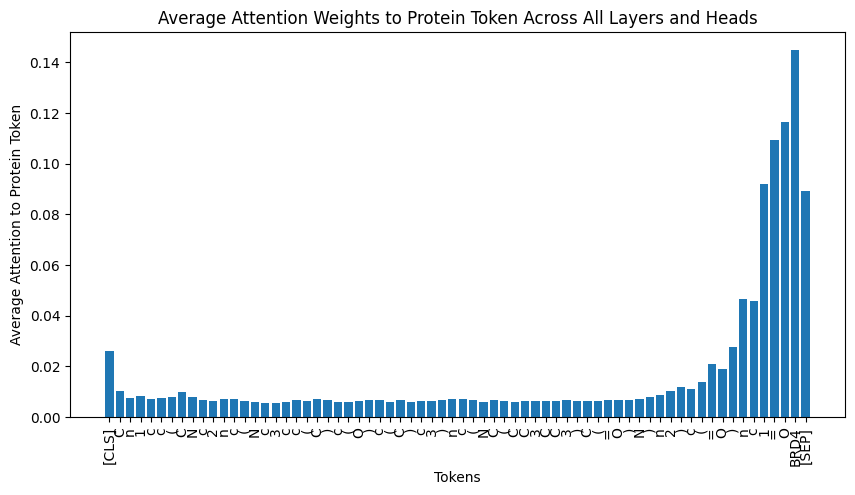

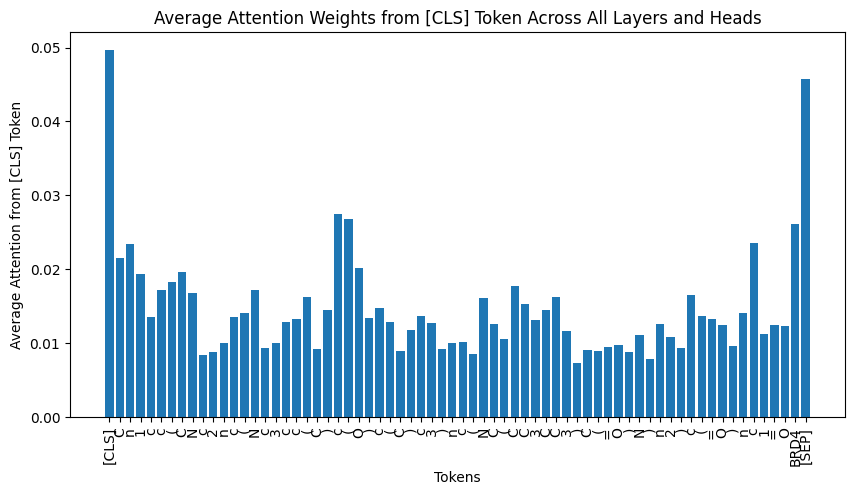

In [119]:
index = 0

# Tokenize the concatenated text
encoded_input = tokenizer(binding_texts[index], padding=True, truncation=True, return_tensors='pt')
input_ids = encoded_input['input_ids'].to(device)
attention_mask = encoded_input['attention_mask'].to(device)

# Enable the output of attention weights
outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
attention = outputs.attentions  # Get the attention weights
attention = [att.cpu().detach().numpy() for att in attention]

# Convert input_ids to tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())

# Find the index of the protein token
protein_token = binding['protein_name'].iloc[index]
protein_token_index = tokens.index(protein_token)


# Initialize a list to store attention weights directed to the protein token
attention_to_protein = []

# Compute the attention weights from all tokens to the protein token
for layer in range(len(attention)):
    layer_attention = []
    for head in range(attention[layer].shape[1]):
        head_attention = attention[layer][0][head][:, protein_token_index]
        layer_attention.append(head_attention)
    attention_to_protein.append(np.mean(layer_attention, axis=0))

# Convert to numpy array for easier manipulation
attention_to_protein = np.array(attention_to_protein)

# Aggregate the attention weights across layers and heads
average_attention_to_protein = np.mean(attention_to_protein, axis=0)


# Visualize the attention to the protein token
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(range(len(tokens)), average_attention_to_protein, tick_label=tokens)
plt.xticks(rotation=90)
plt.xlabel('Tokens')
plt.ylabel('Average Attention to Protein Token')
plt.title('Average Attention Weights to Protein Token Across All Layers and Heads')
plt.show()

# The [CLS] token is usually the first token in the sequence
cls_token_index = 0

# Initialize a list to store attention weights from the [CLS] token
attention_from_cls = []

# Compute the attention weights from the [CLS] token to all other tokens
for layer in range(len(attention)):
    layer_attention = []
    for head in range(attention[layer].shape[1]):
        head_attention = attention[layer][0][head][cls_token_index, :]
        layer_attention.append(head_attention)
    attention_from_cls.append(np.mean(layer_attention, axis=0))

# Convert to numpy array for easier manipulation
attention_from_cls = np.array(attention_from_cls)

# Aggregate the attention weights across layers and heads
average_attention_from_cls = np.mean(attention_from_cls, axis=0)

# Visualize the attention from the [CLS] token to all other tokens
plt.figure(figsize=(10, 5))
plt.bar(range(len(tokens)), average_attention_from_cls, tick_label=tokens)
plt.xticks(rotation=90)
plt.xlabel('Tokens')
plt.ylabel('Average Attention from [CLS] Token')
plt.title('Average Attention Weights from [CLS] Token Across All Layers and Heads')
plt.show()

<ipython-input-116-284b0d77e58b>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])  # Adjust layout to make space for the title and color bar


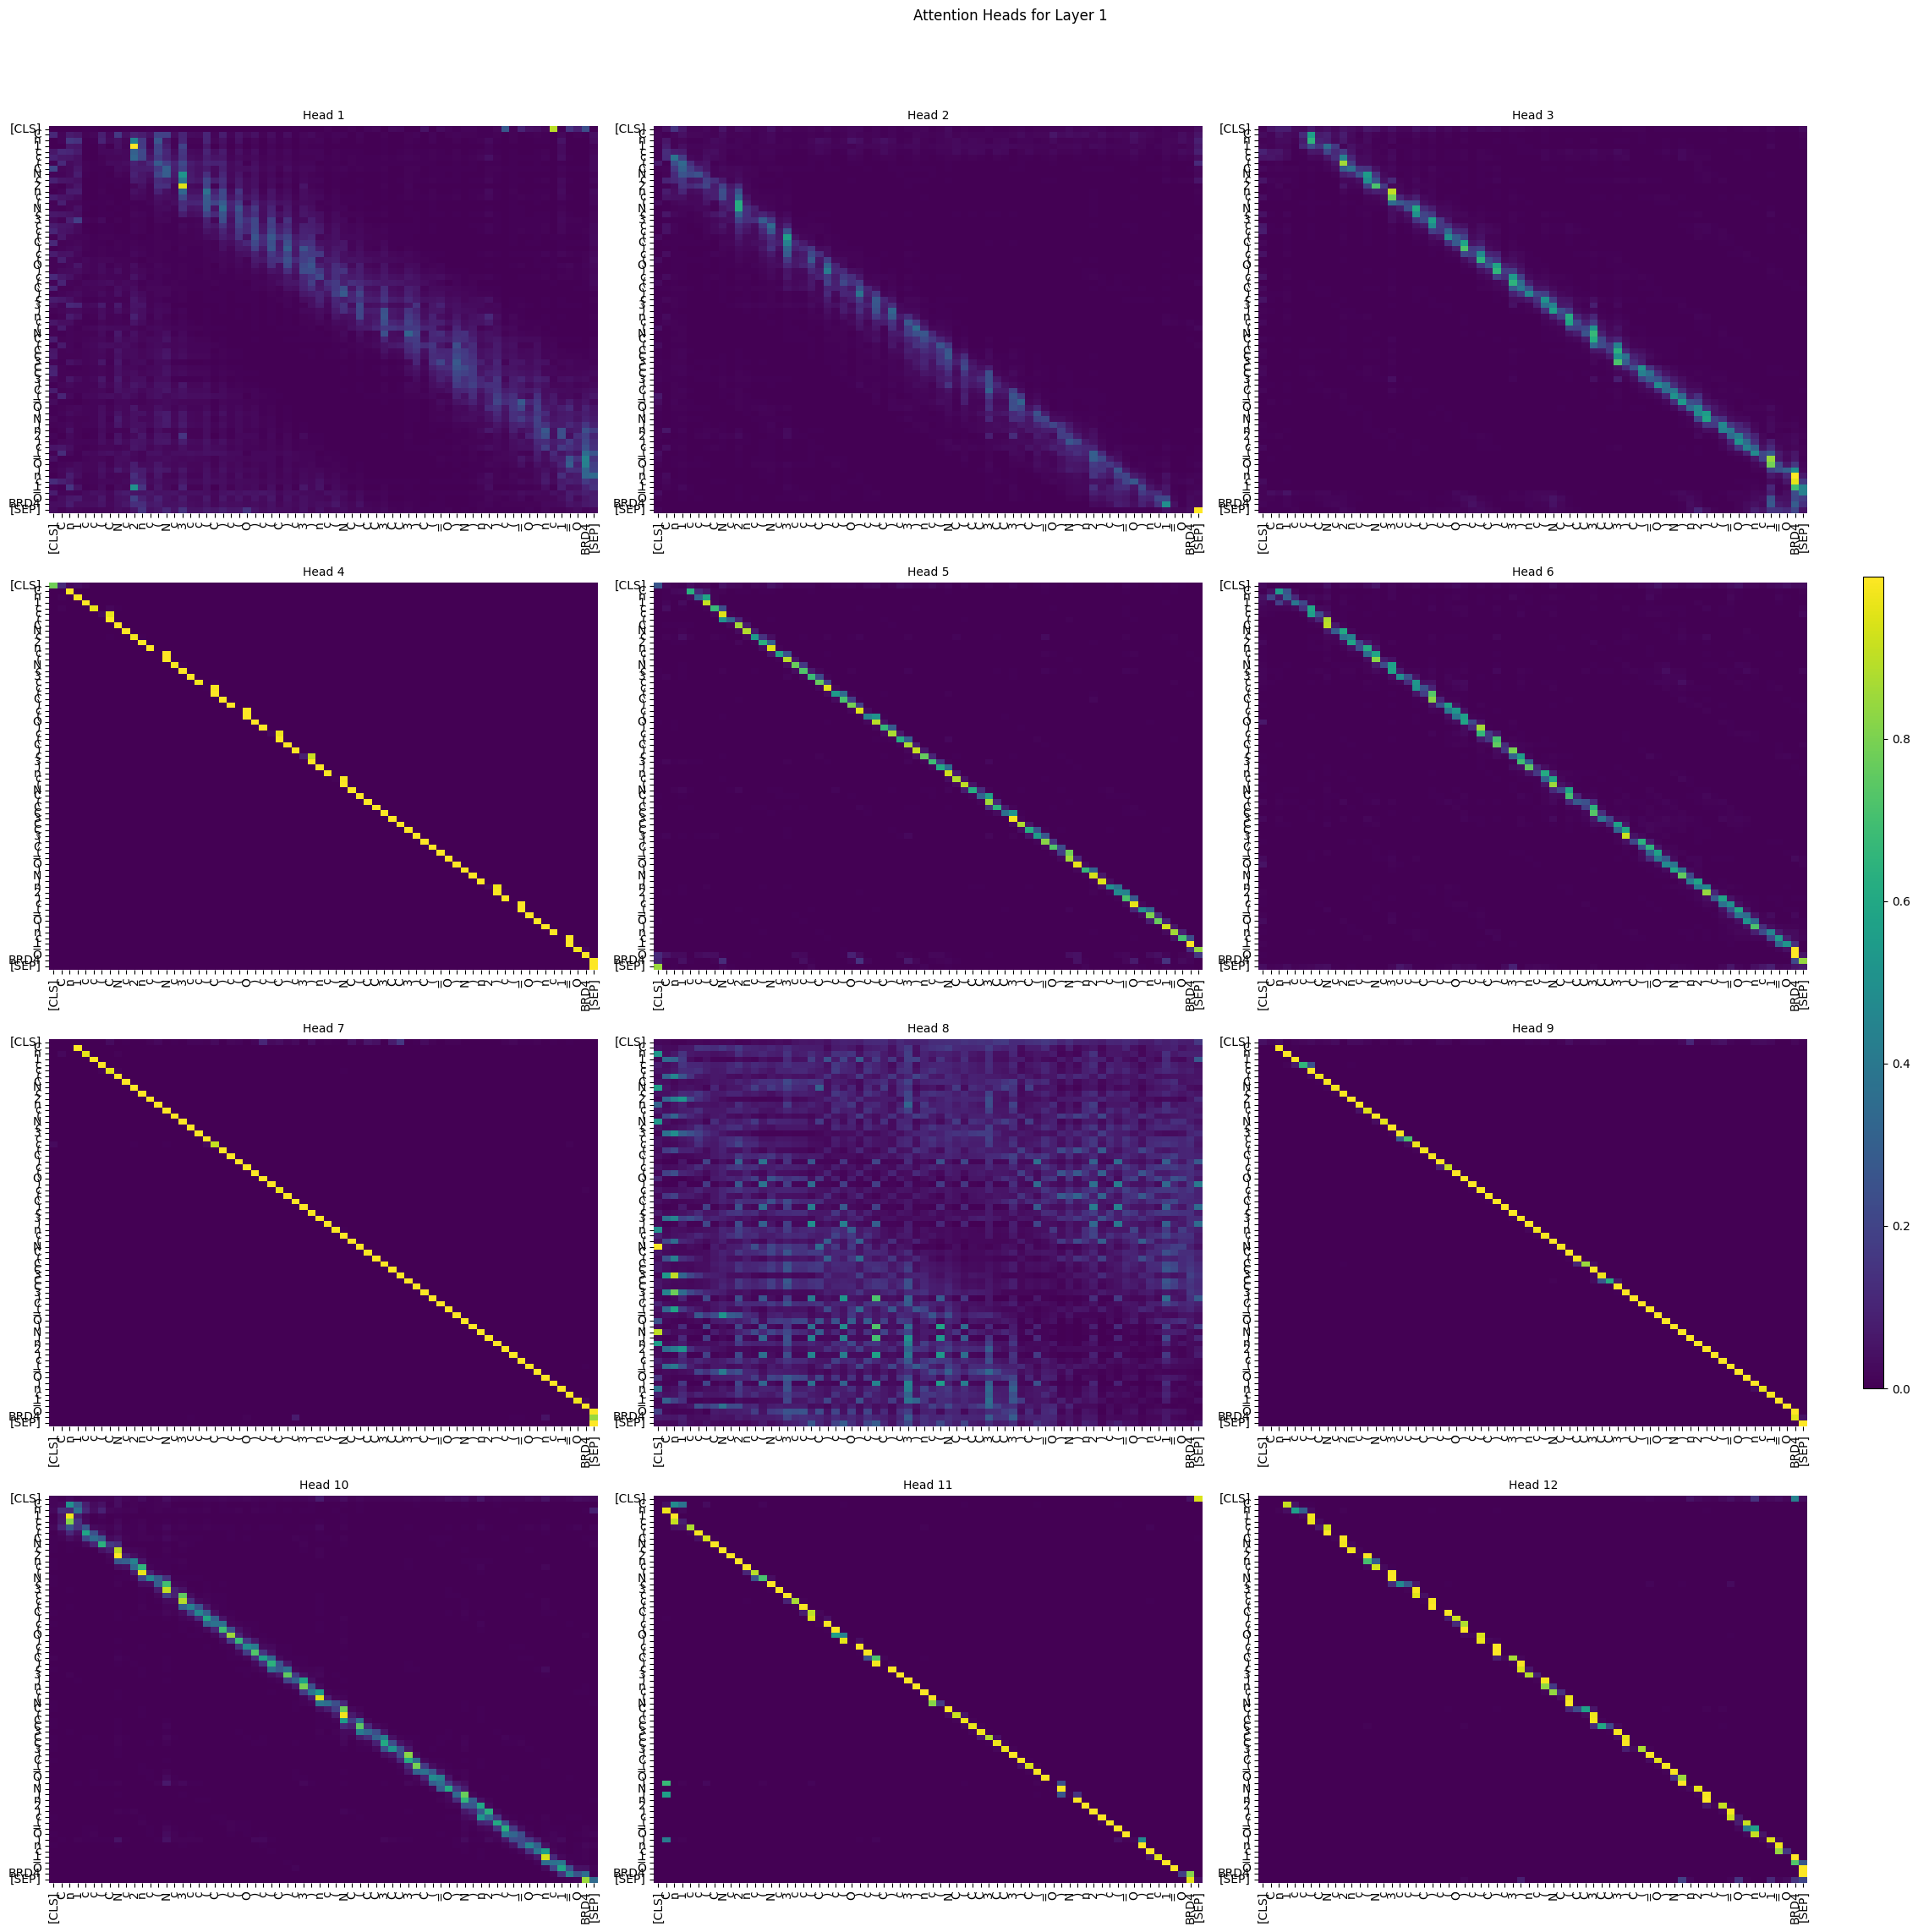

<ipython-input-116-284b0d77e58b>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])  # Adjust layout to make space for the title and color bar


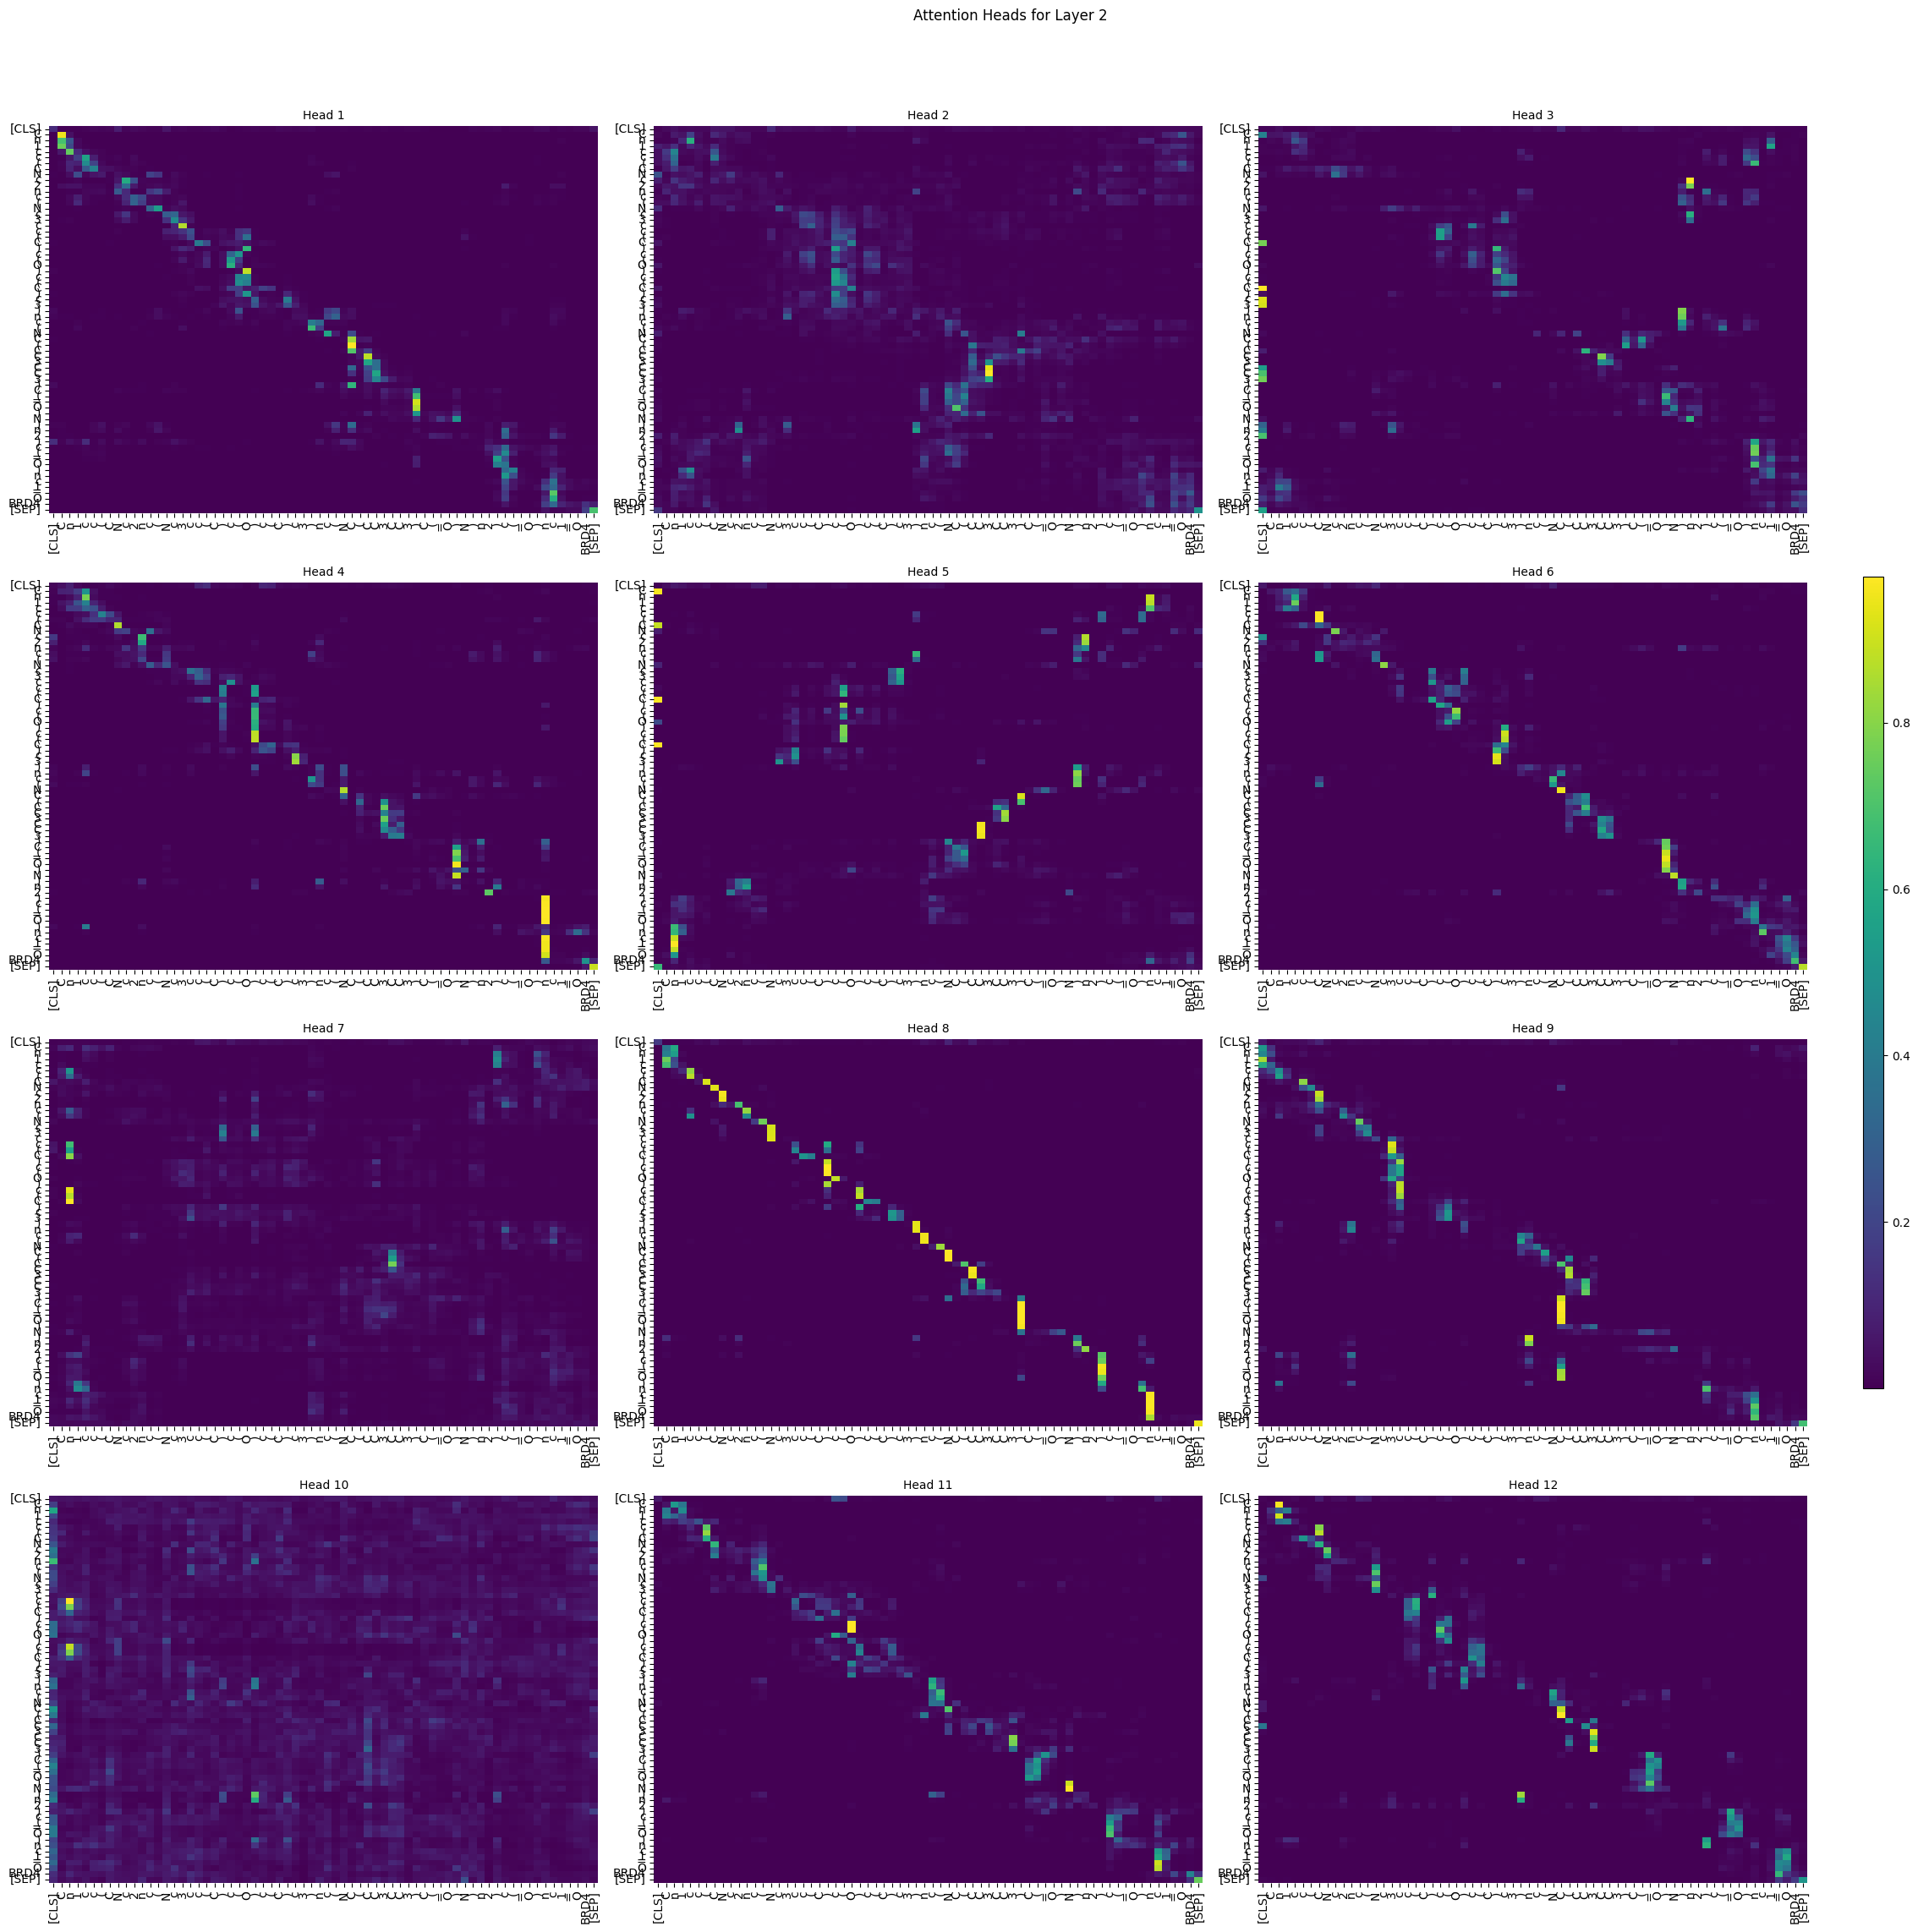

<ipython-input-116-284b0d77e58b>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])  # Adjust layout to make space for the title and color bar


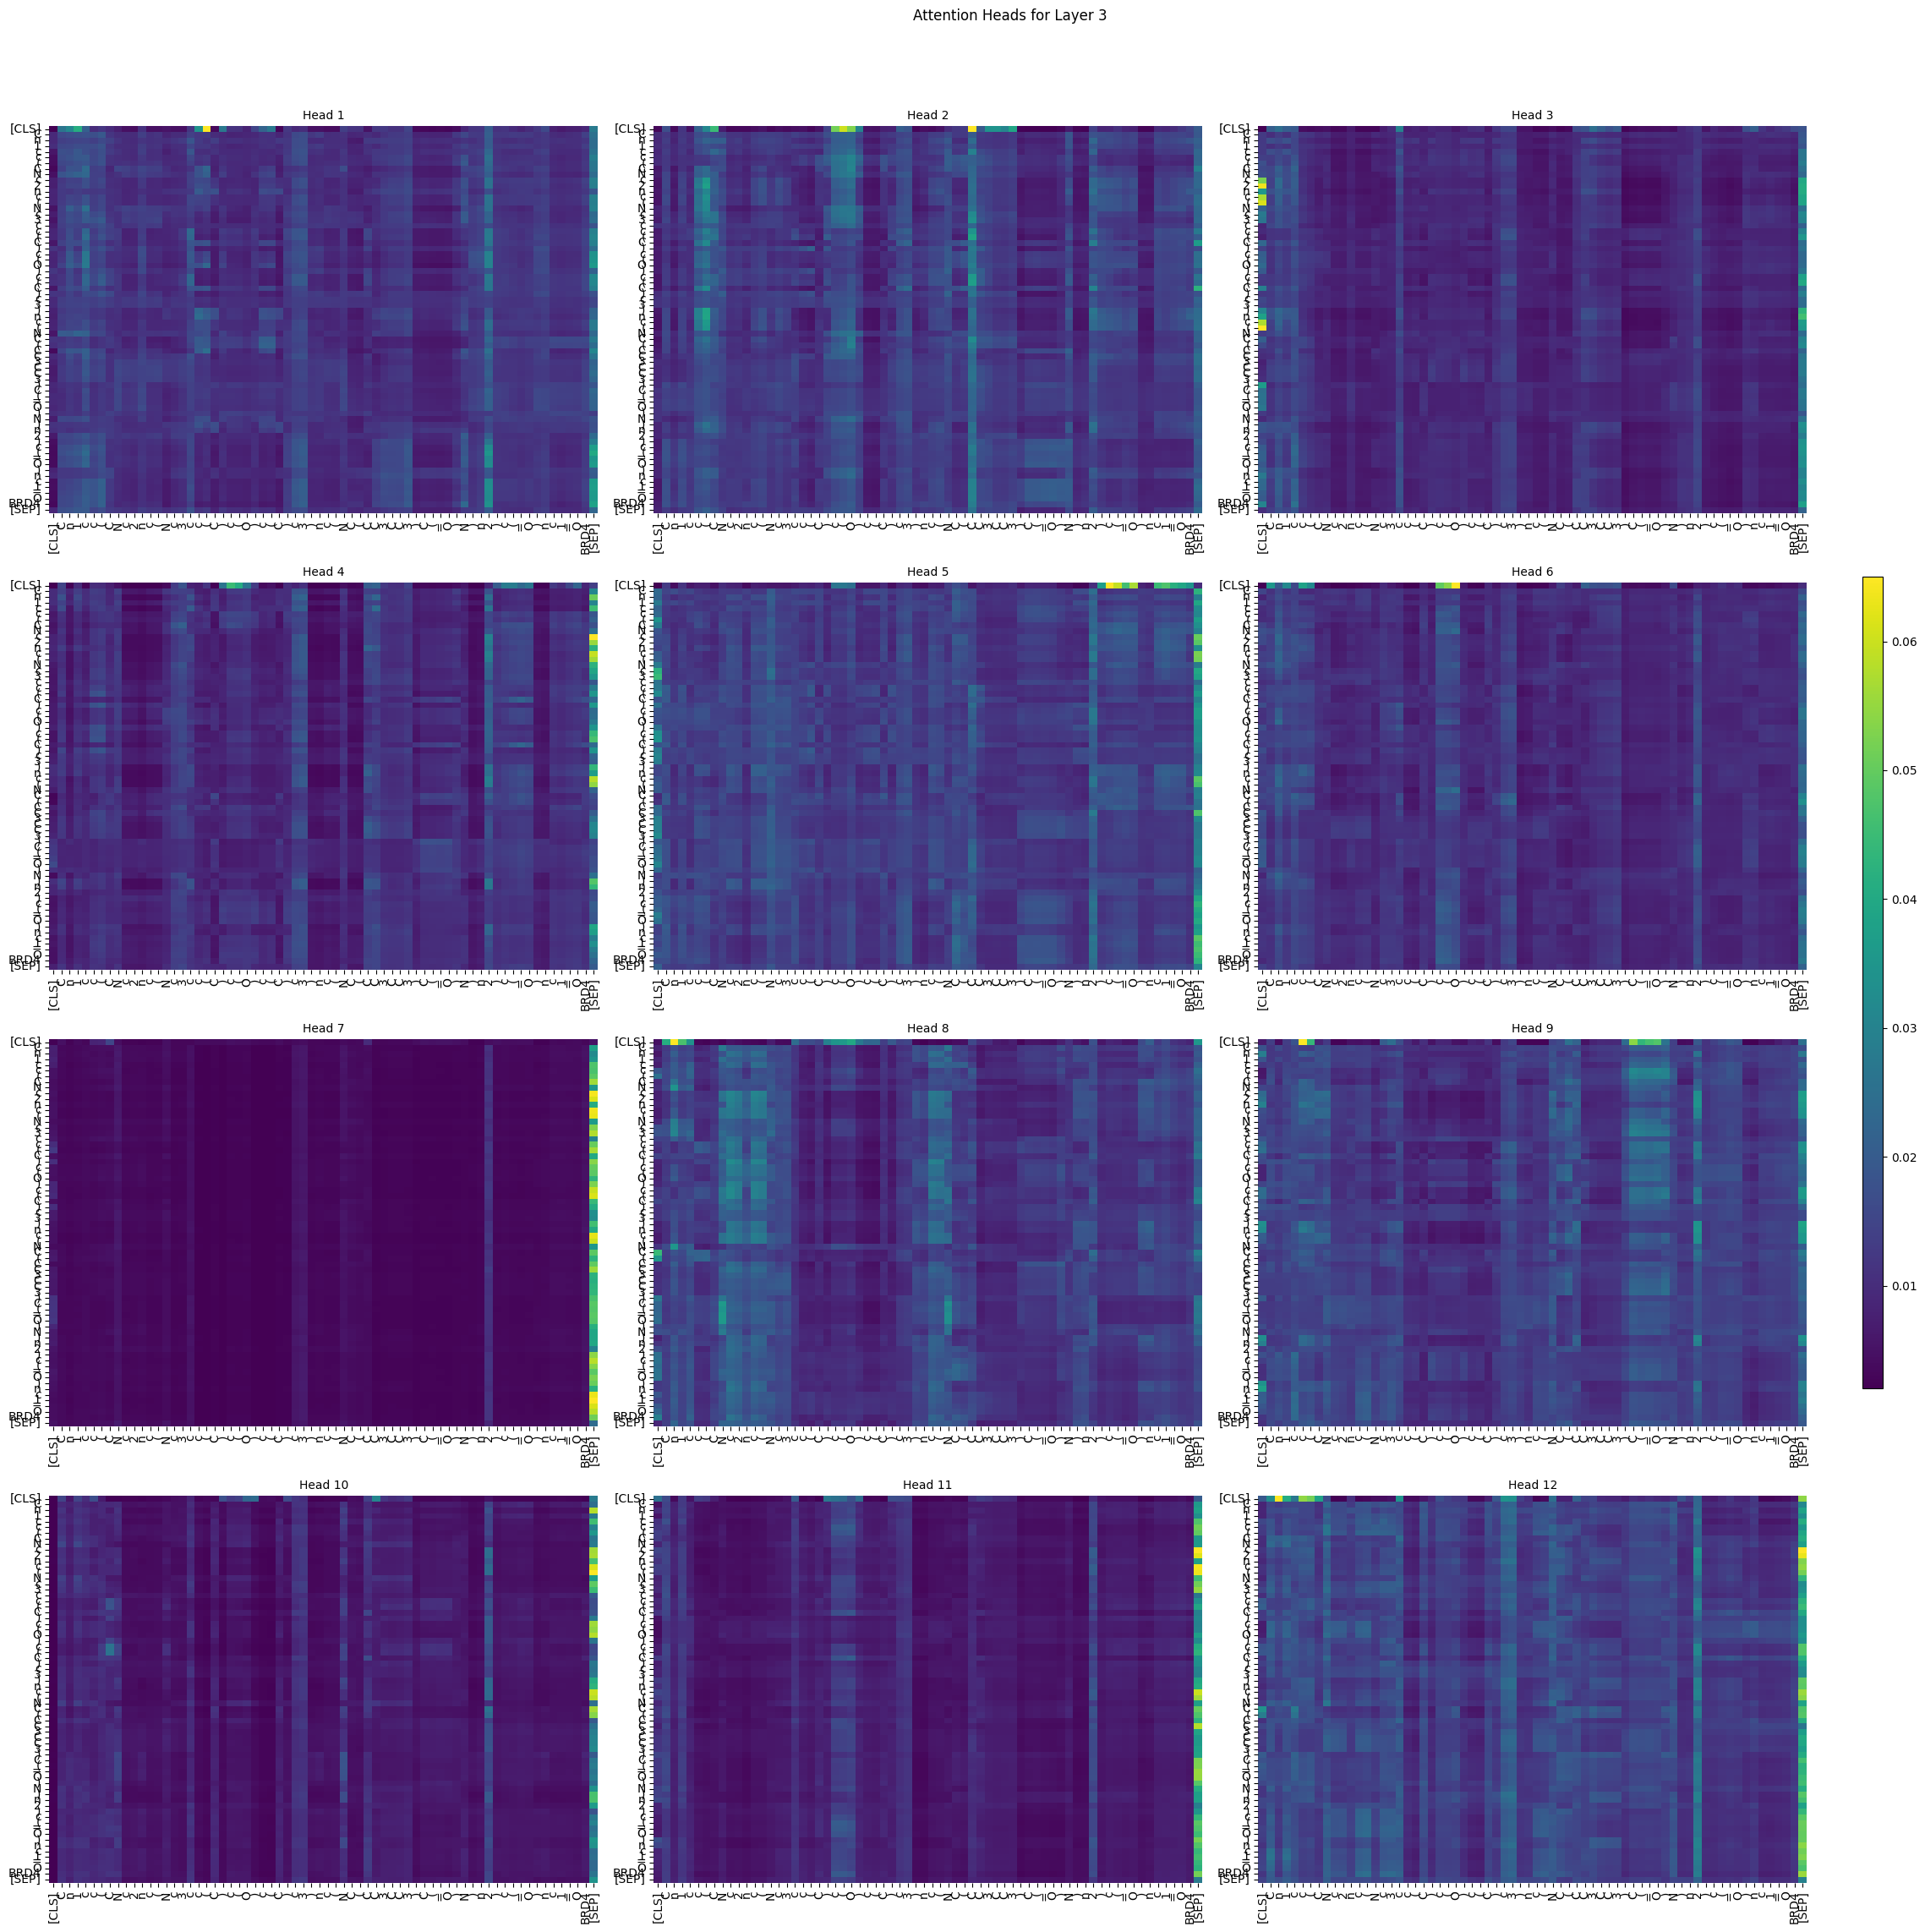

In [116]:
index = 0

encoded_input = tokenizer(binding_texts[index], padding=True, truncation=True, return_tensors='pt')
input_ids = encoded_input['input_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
attention_mask = encoded_input['attention_mask'].to('cuda' if torch.cuda.is_available() else 'cpu')

# Enable the output of attention weights
outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
attention = outputs.attentions  # Get the attention weights
attention = [att.cpu().detach().numpy() for att in attention]

# Convert input_ids to tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())

# Number of layers and heads
num_layers = len(attention)
num_heads = attention[0].shape[1]

# Plot each layer separately with 4x3 grid layout
for layer in range(num_layers):
    fig, axes = plt.subplots(4, 3, figsize=(24, 24))  # 4 rows and 3 columns
    fig.suptitle(f'Attention Heads for Layer {layer + 1}', fontsize=12)
    axes = axes.flatten()
    for head in range(num_heads):
        ax = axes[head]
        attention_weights = attention[layer][0][head]
        sns.heatmap(attention_weights, xticklabels=tokens, yticklabels=tokens, cmap='viridis', ax=ax, cbar=False)
        ax.set_title(f'Head {head + 1}', fontsize=10)
        ax.tick_params(labelsize=12)
        ax.set_xticklabels(tokens, rotation=90, ha='center', fontsize=10)  # Rotate x-axis labels for better readability
        ax.set_yticklabels(tokens, fontsize=10)

    # Add color bar to the rightmost subplot
    cbar_ax = fig.add_axes([0.92, 0.3, 0.01, 0.4])
    fig.colorbar(axes[-1].collections[0], cax=cbar_ax)

    # Adjust layout manually
    plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])  # Adjust layout to make space for the title and color bar
    plt.show()

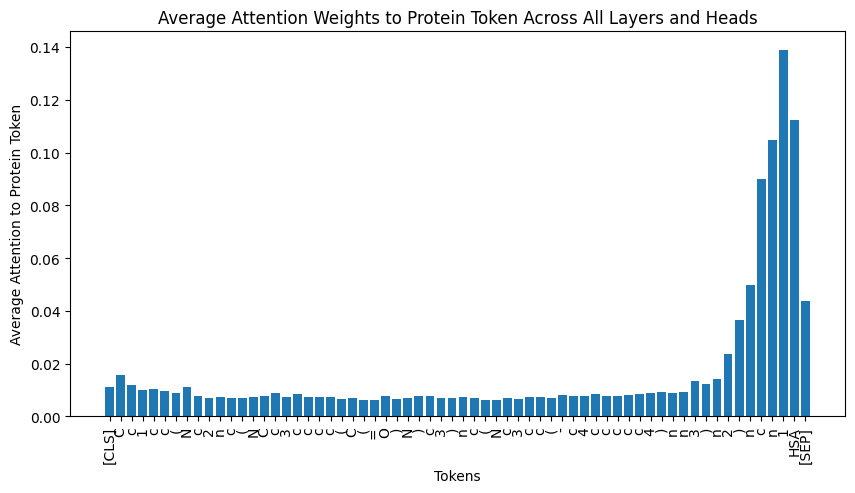

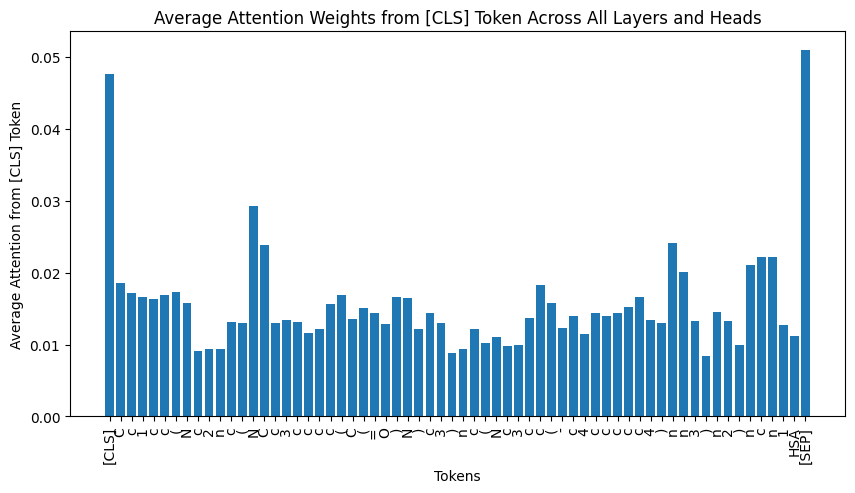

In [120]:
index = 0

# Tokenize the concatenated text
encoded_input = tokenizer(nonbinding_texts[index], padding=True, truncation=True, return_tensors='pt')
input_ids = encoded_input['input_ids'].to(device)
attention_mask = encoded_input['attention_mask'].to(device)

# Enable the output of attention weights
outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
attention = outputs.attentions  # Get the attention weights
attention = [att.cpu().detach().numpy() for att in attention]

# Convert input_ids to tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())

# Find the index of the protein token
protein_token = non_binding['protein_name'].iloc[index]
protein_token_index = tokens.index(protein_token)


# Initialize a list to store attention weights directed to the protein token
attention_to_protein = []

# Compute the attention weights from all tokens to the protein token
for layer in range(len(attention)):
    layer_attention = []
    for head in range(attention[layer].shape[1]):
        head_attention = attention[layer][0][head][:, protein_token_index]
        layer_attention.append(head_attention)
    attention_to_protein.append(np.mean(layer_attention, axis=0))

# Convert to numpy array for easier manipulation
attention_to_protein = np.array(attention_to_protein)

# Aggregate the attention weights across layers and heads
average_attention_to_protein = np.mean(attention_to_protein, axis=0)


# Visualize the attention to the protein token
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(range(len(tokens)), average_attention_to_protein, tick_label=tokens)
plt.xticks(rotation=90)
plt.xlabel('Tokens')
plt.ylabel('Average Attention to Protein Token')
plt.title('Average Attention Weights to Protein Token Across All Layers and Heads')
plt.show()

# The [CLS] token is usually the first token in the sequence
cls_token_index = 0

# Initialize a list to store attention weights from the [CLS] token
attention_from_cls = []

# Compute the attention weights from the [CLS] token to all other tokens
for layer in range(len(attention)):
    layer_attention = []
    for head in range(attention[layer].shape[1]):
        head_attention = attention[layer][0][head][cls_token_index, :]
        layer_attention.append(head_attention)
    attention_from_cls.append(np.mean(layer_attention, axis=0))

# Convert to numpy array for easier manipulation
attention_from_cls = np.array(attention_from_cls)

# Aggregate the attention weights across layers and heads
average_attention_from_cls = np.mean(attention_from_cls, axis=0)

# Visualize the attention from the [CLS] token to all other tokens
plt.figure(figsize=(10, 5))
plt.bar(range(len(tokens)), average_attention_from_cls, tick_label=tokens)
plt.xticks(rotation=90)
plt.xlabel('Tokens')
plt.ylabel('Average Attention from [CLS] Token')
plt.title('Average Attention Weights from [CLS] Token Across All Layers and Heads')
plt.show()

<ipython-input-118-4dbae5037af9>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])  # Adjust layout to make space for the title and color bar


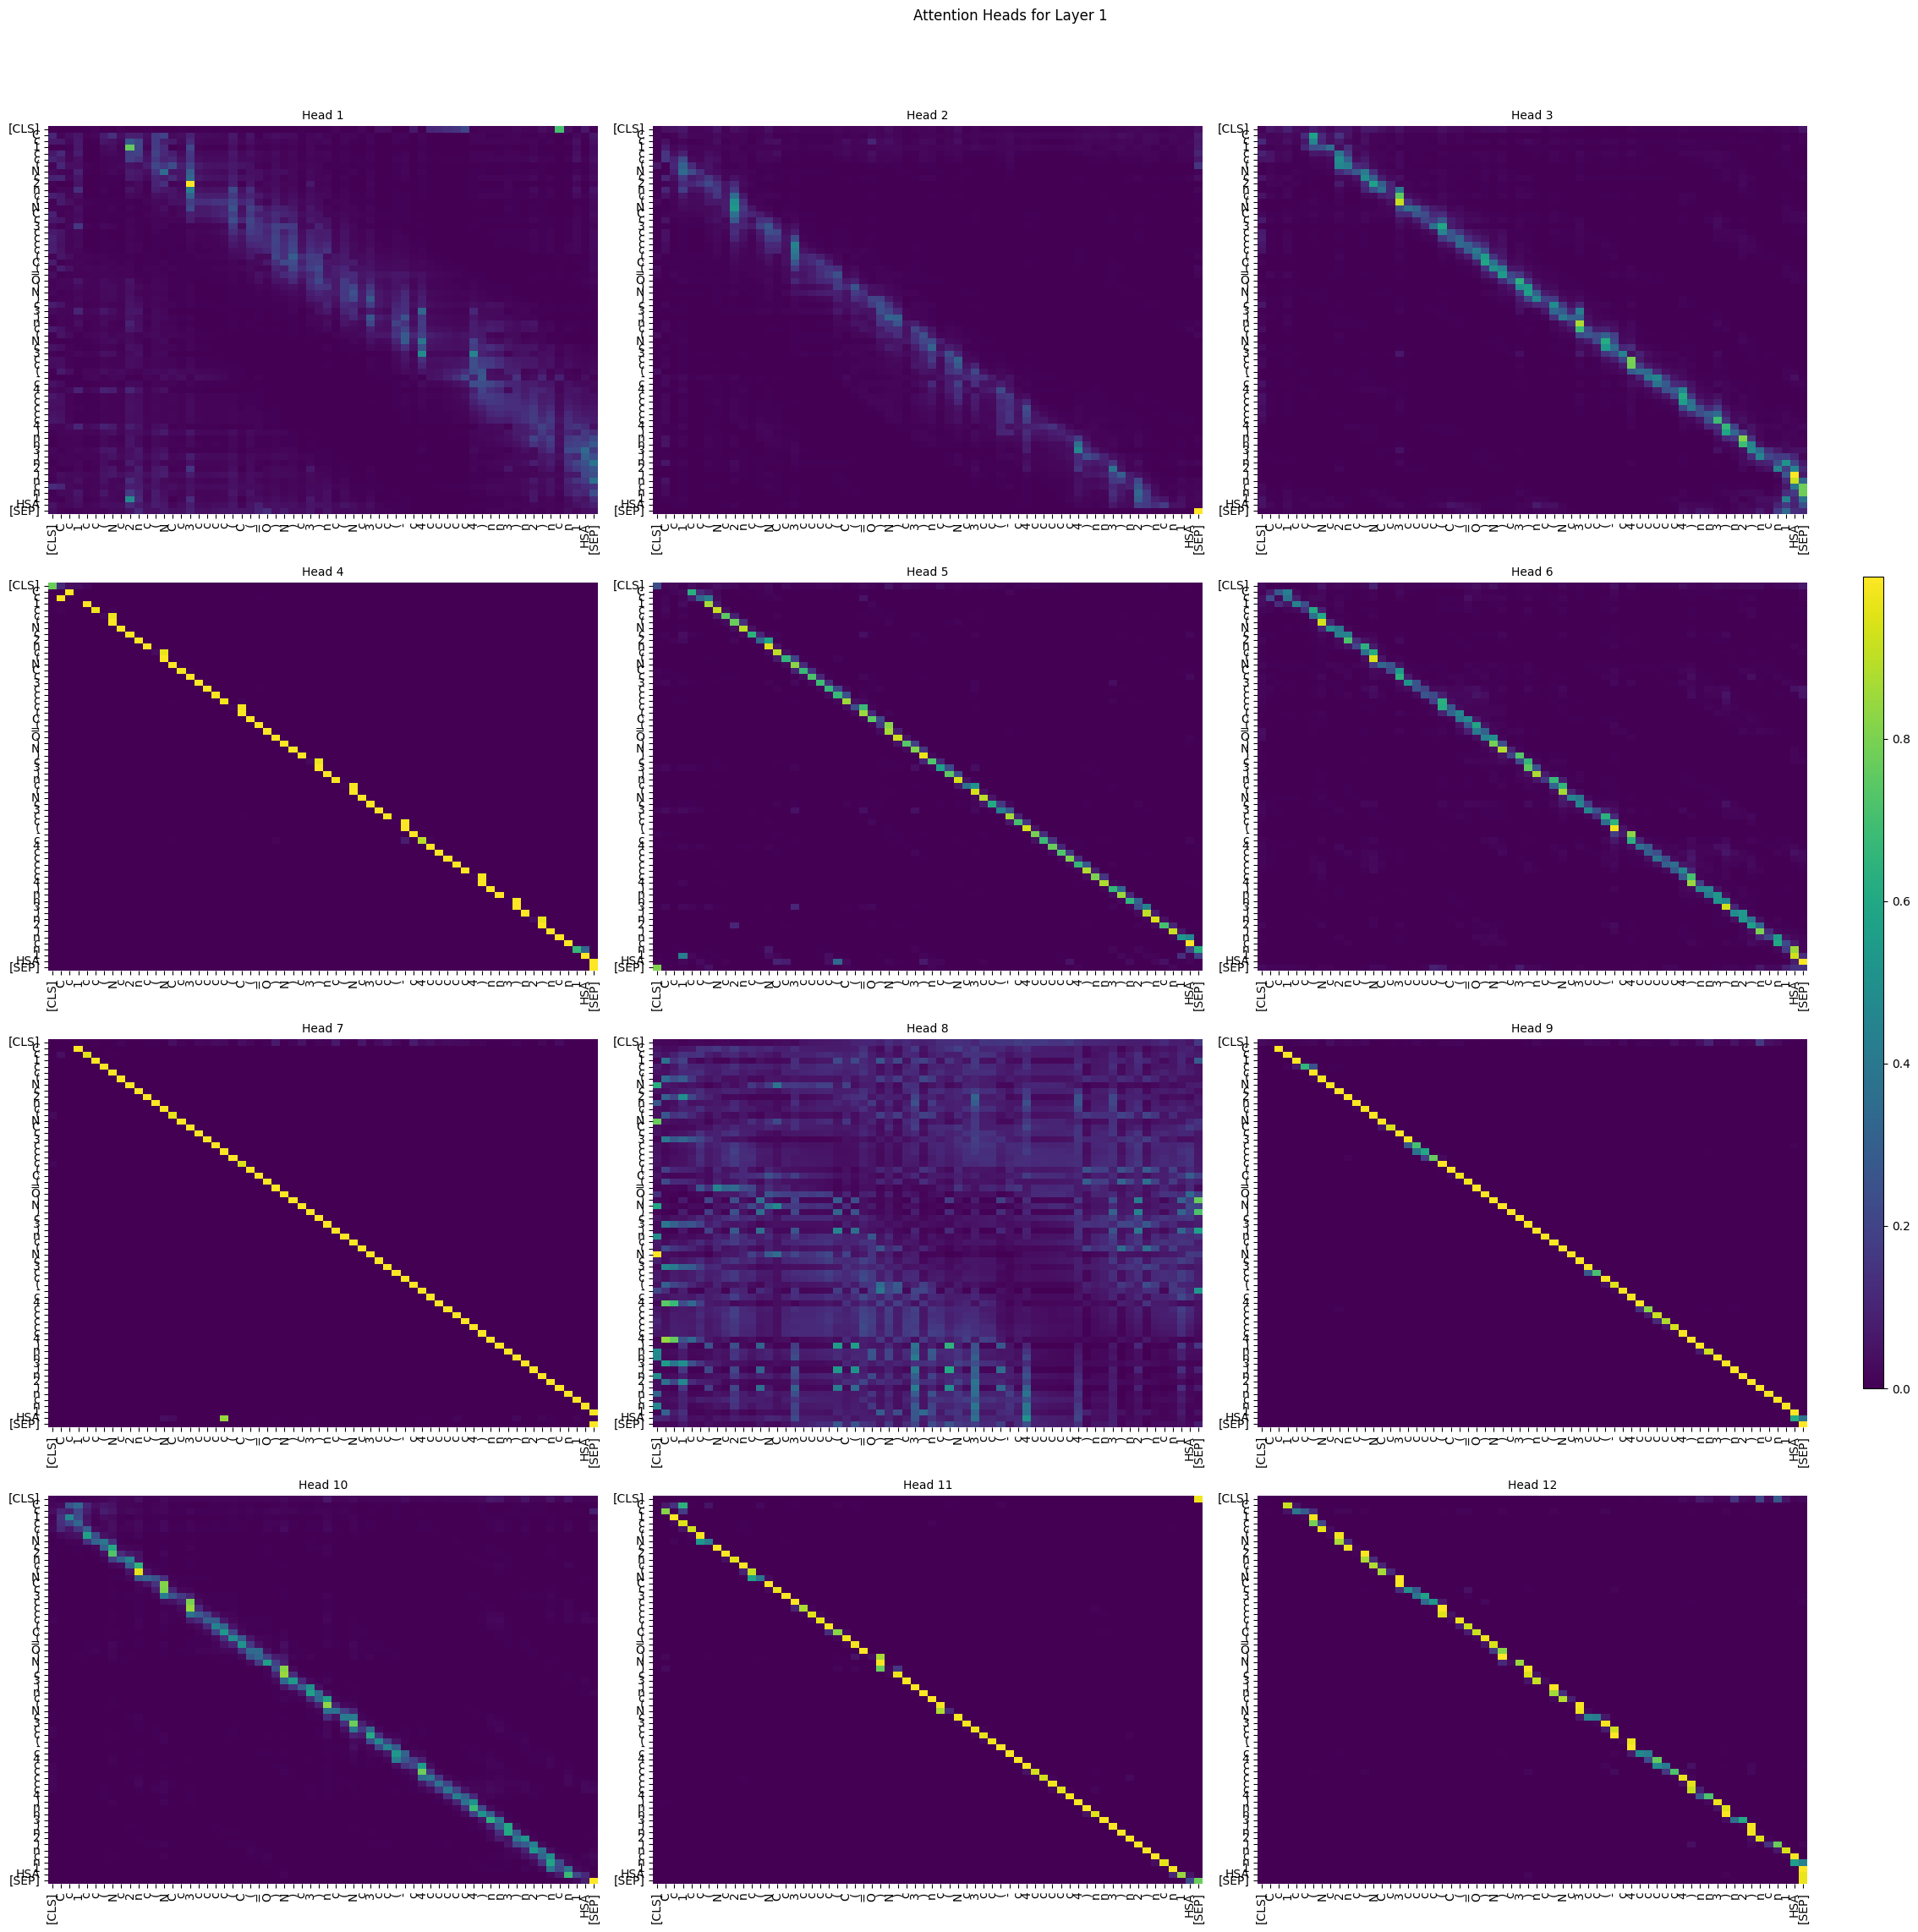

<ipython-input-118-4dbae5037af9>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])  # Adjust layout to make space for the title and color bar


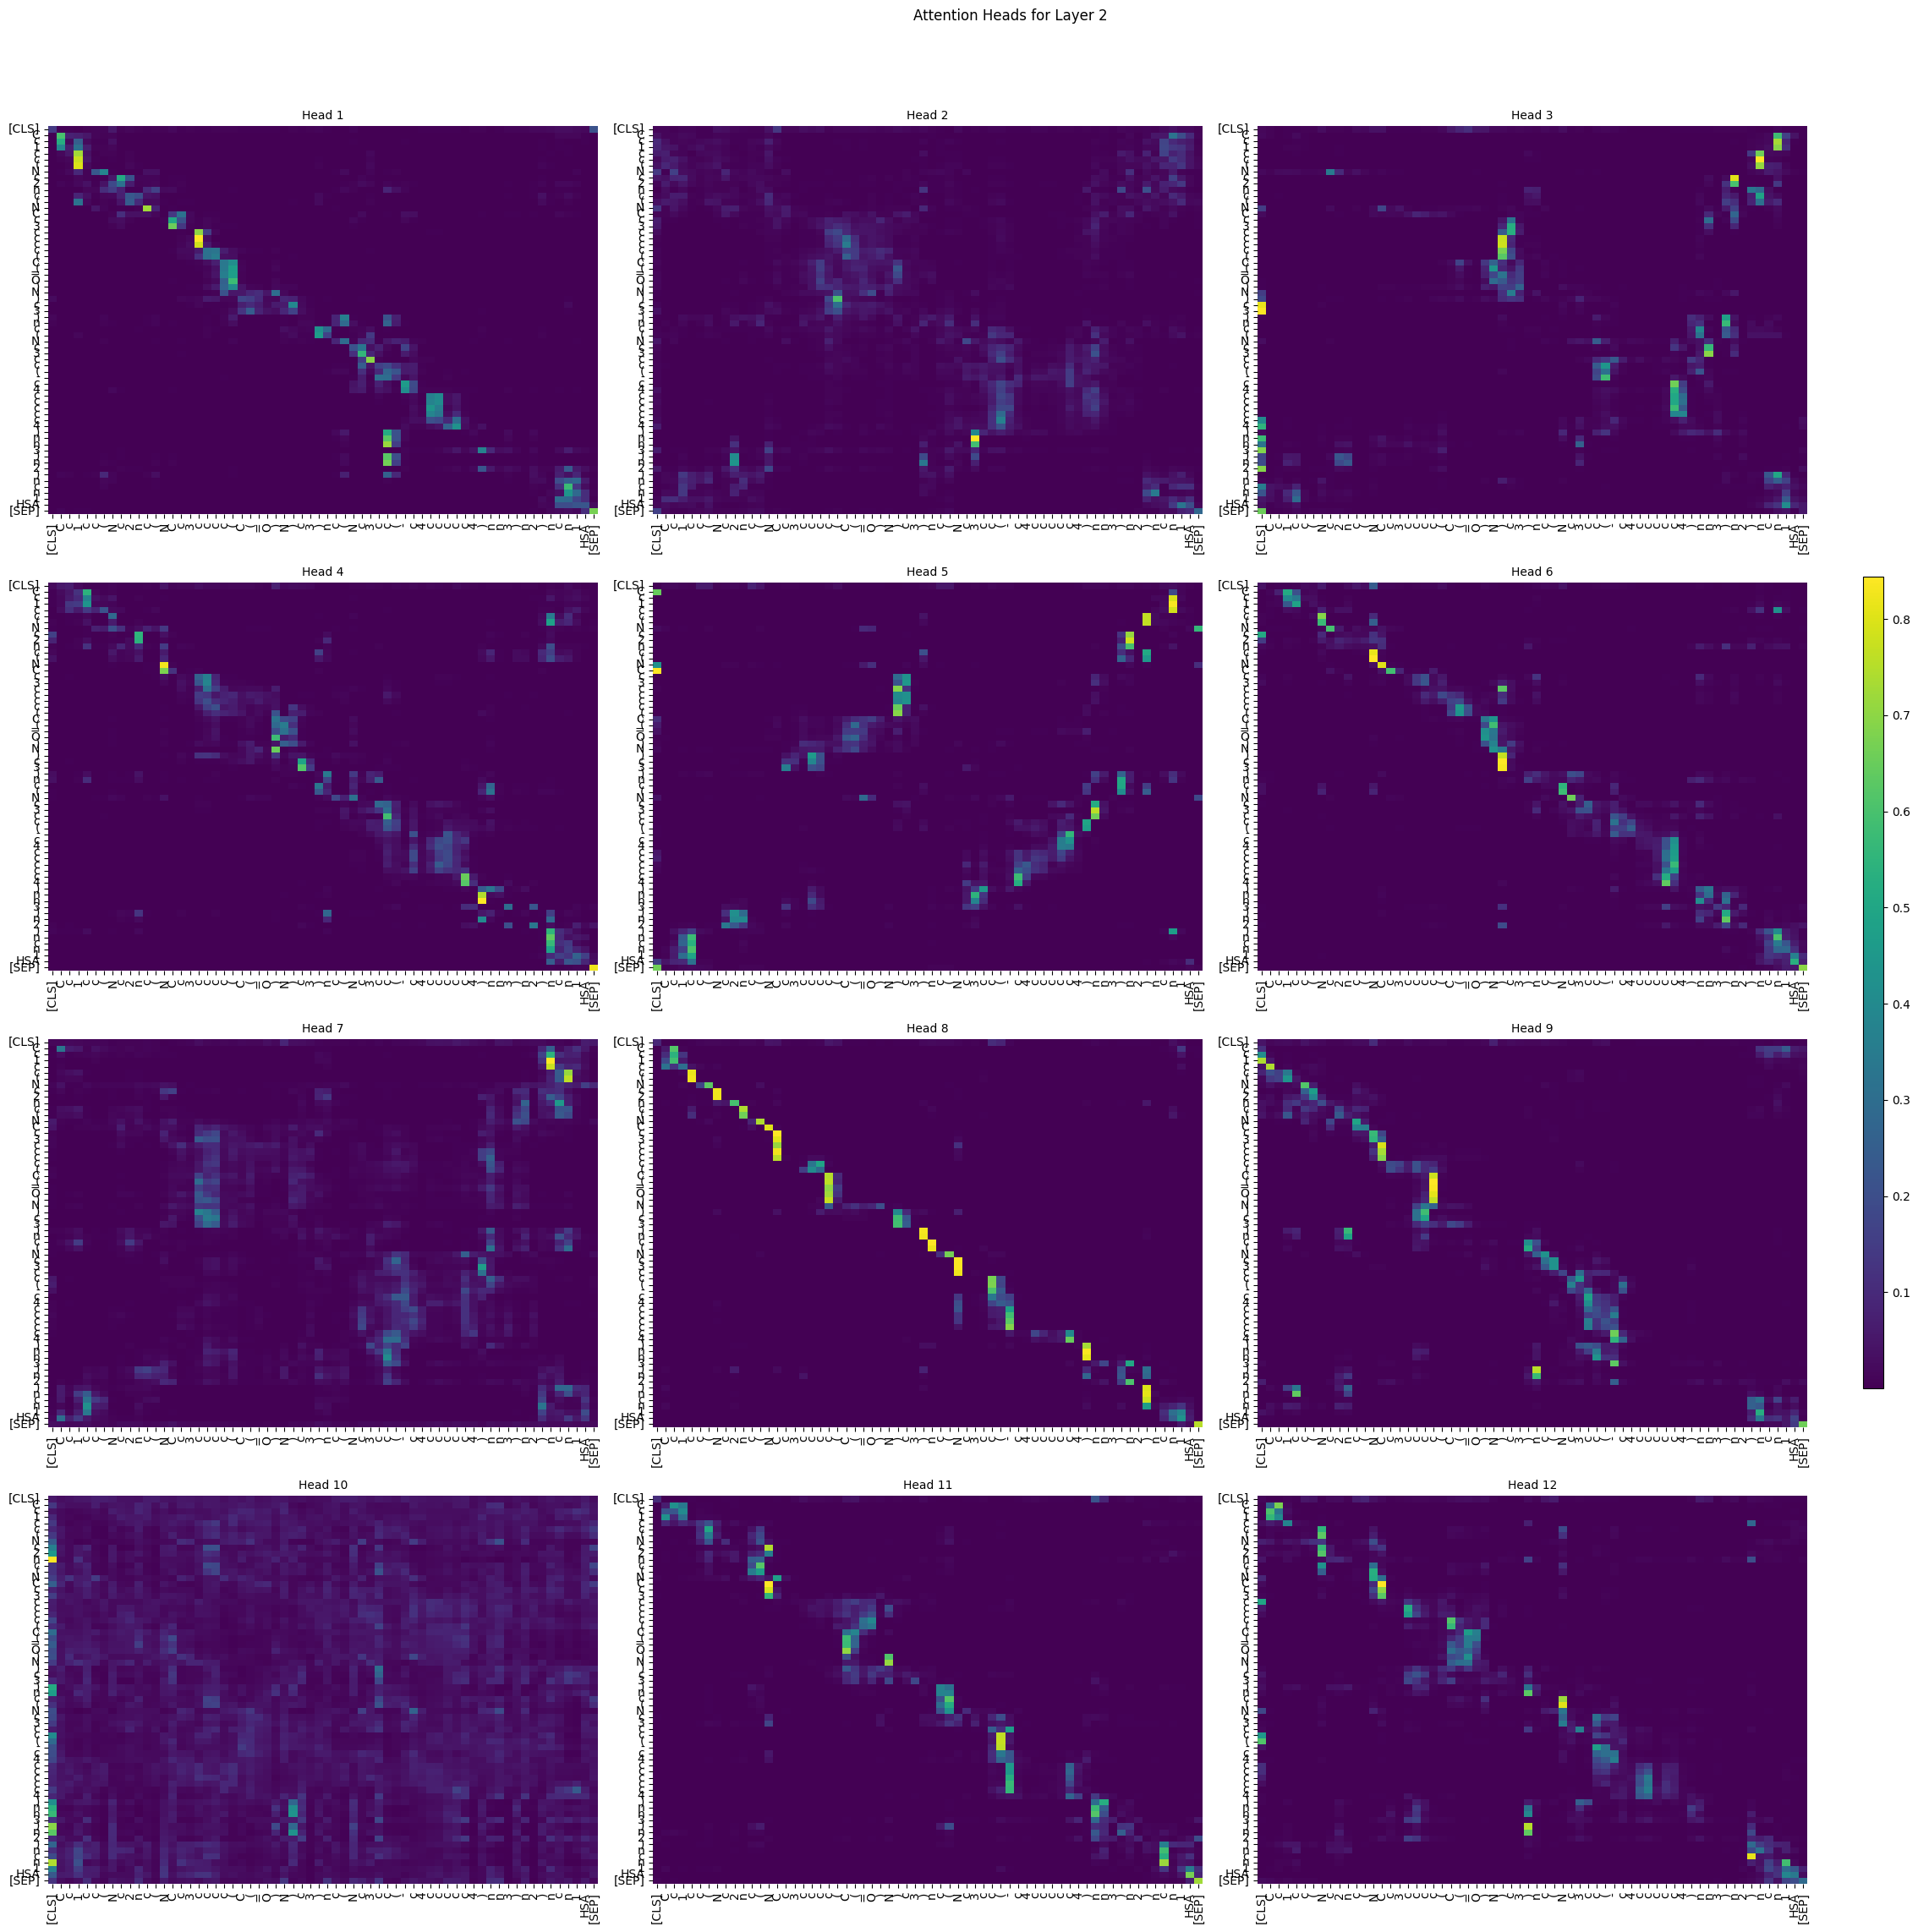

<ipython-input-118-4dbae5037af9>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])  # Adjust layout to make space for the title and color bar


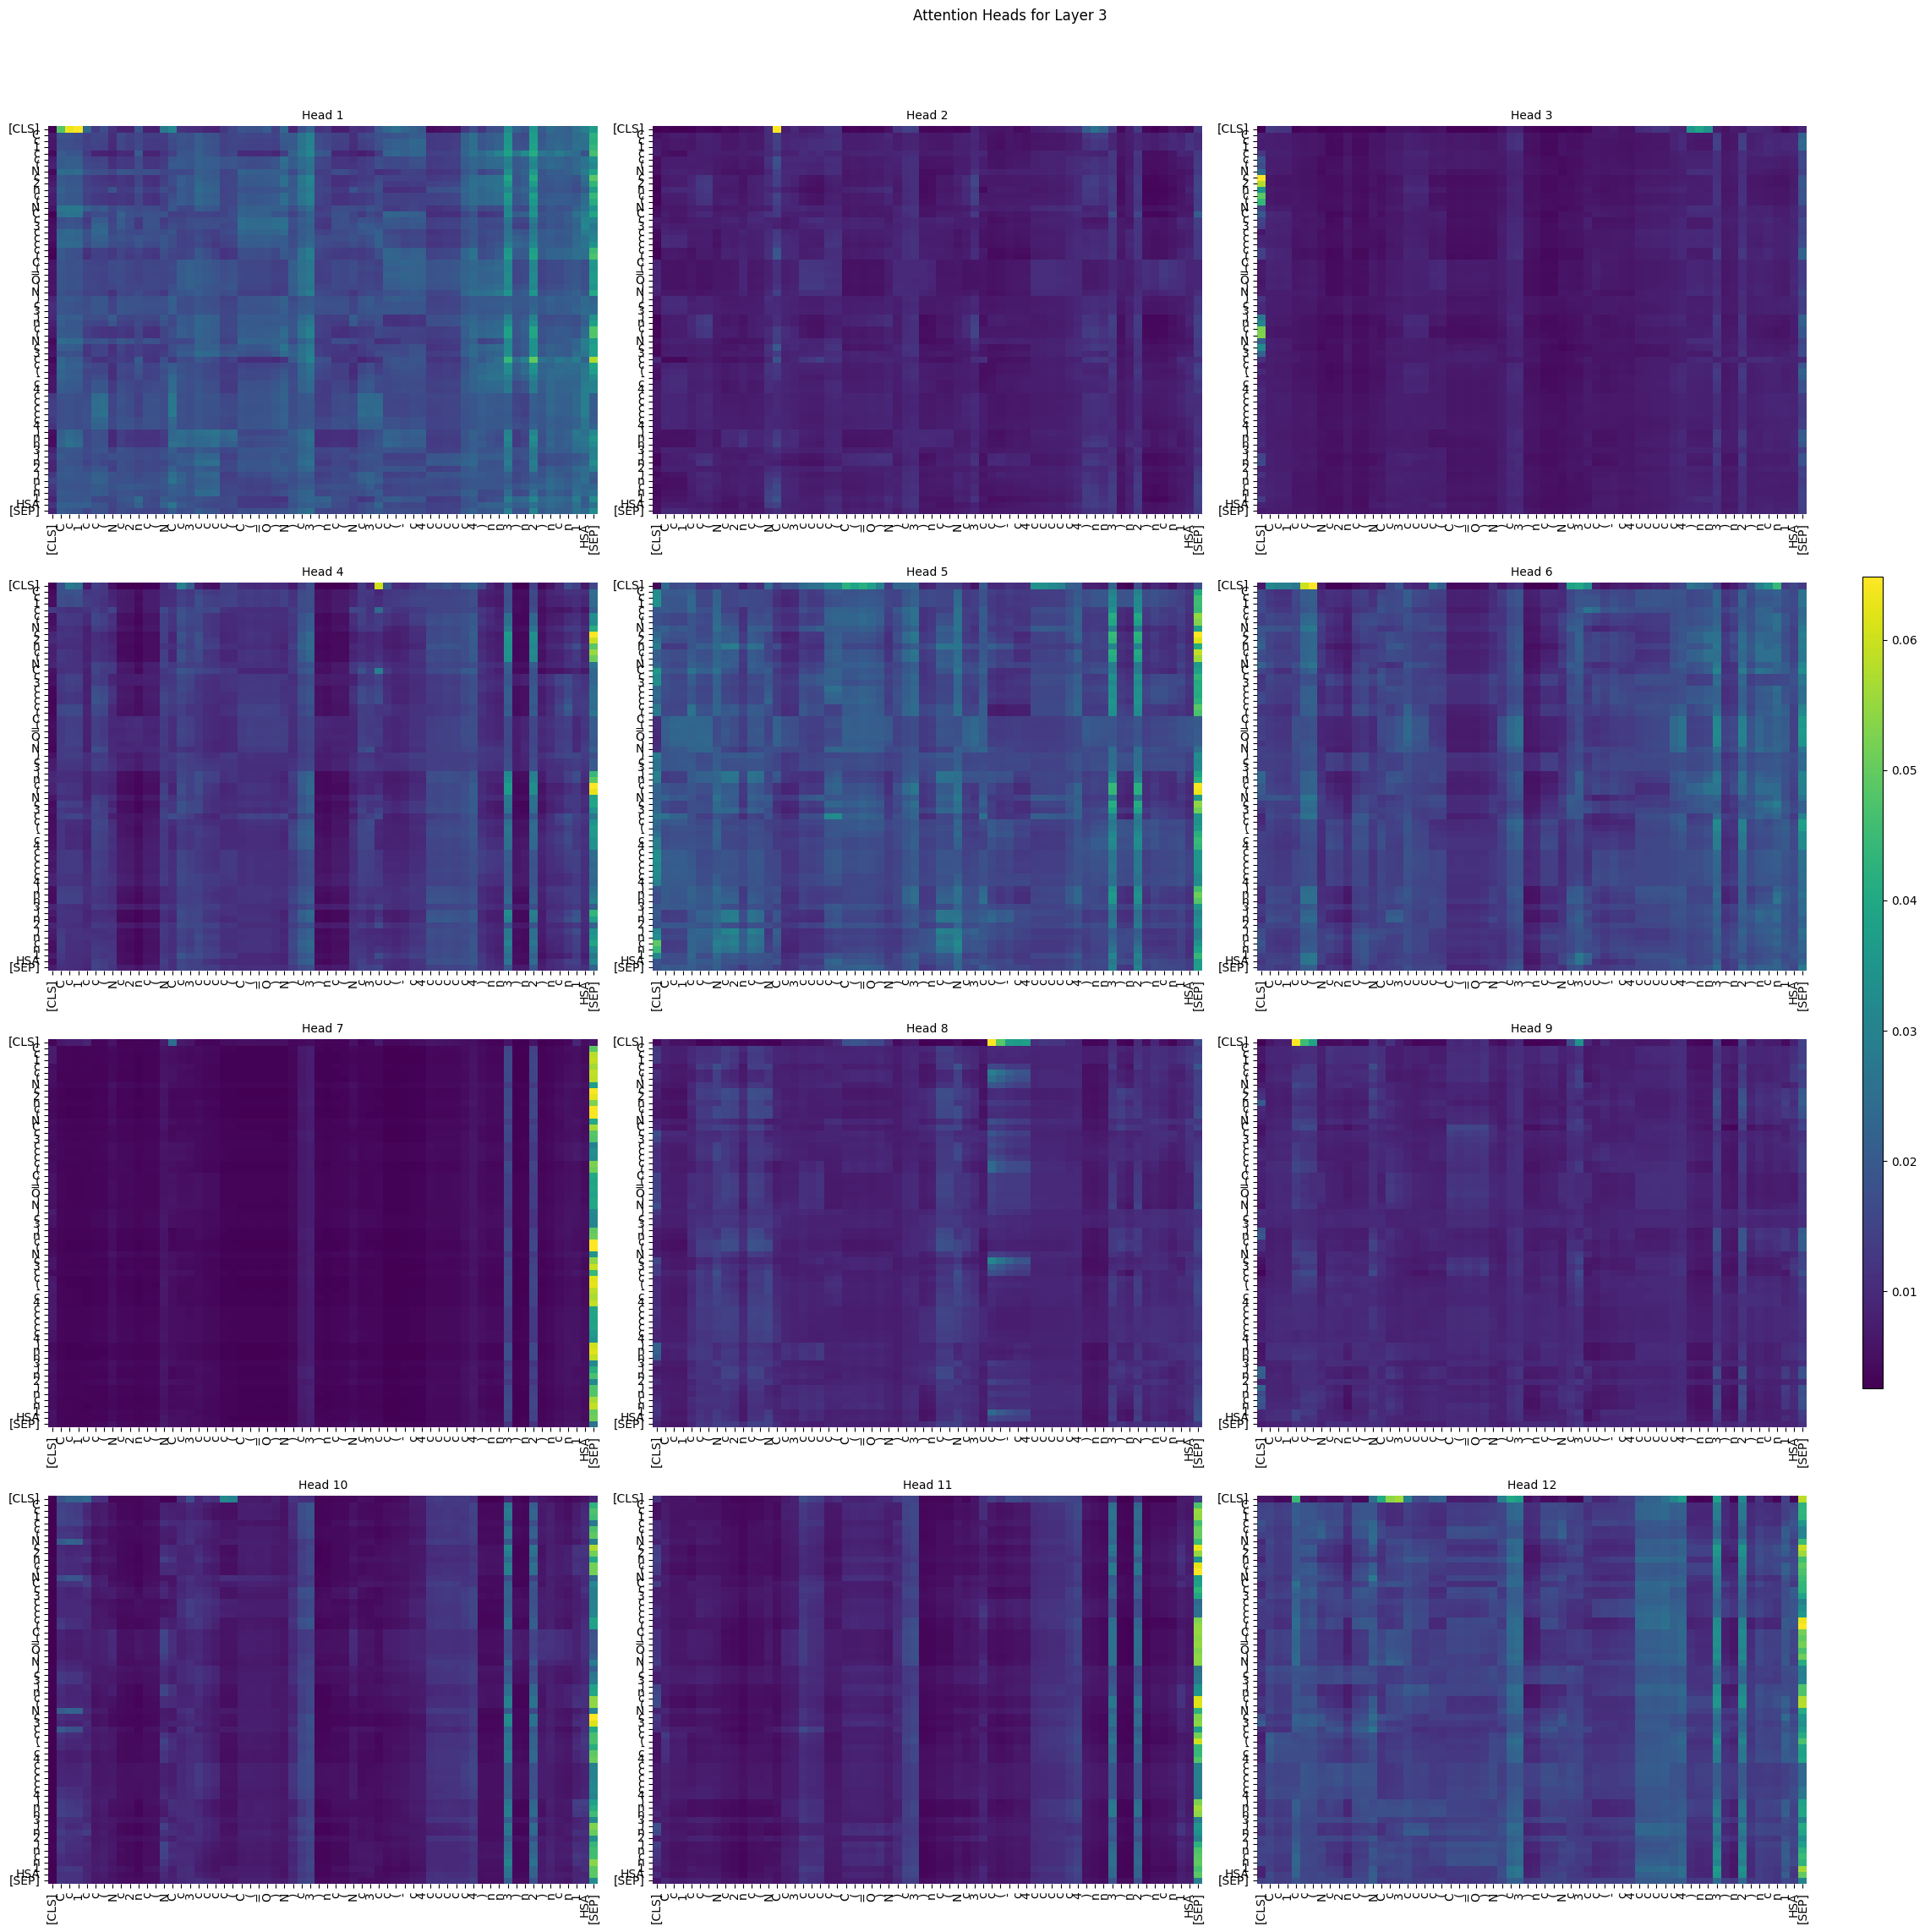

In [118]:
index = 0

encoded_input = tokenizer(nonbinding_texts[index], padding=True, truncation=True, return_tensors='pt')
input_ids = encoded_input['input_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
attention_mask = encoded_input['attention_mask'].to('cuda' if torch.cuda.is_available() else 'cpu')

# Enable the output of attention weights
outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
attention = outputs.attentions  # Get the attention weights
attention = [att.cpu().detach().numpy() for att in attention]

# Convert input_ids to tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())

# Number of layers and heads
num_layers = len(attention)
num_heads = attention[0].shape[1]

# Plot each layer separately with 4x3 grid layout
for layer in range(num_layers):
    fig, axes = plt.subplots(4, 3, figsize=(24, 24))  # 4 rows and 3 columns
    fig.suptitle(f'Attention Heads for Layer {layer + 1}', fontsize=12)
    axes = axes.flatten()
    for head in range(num_heads):
        ax = axes[head]
        attention_weights = attention[layer][0][head]
        sns.heatmap(attention_weights, xticklabels=tokens, yticklabels=tokens, cmap='viridis', ax=ax, cbar=False)
        ax.set_title(f'Head {head + 1}', fontsize=10)
        ax.tick_params(labelsize=12)
        ax.set_xticklabels(tokens, rotation=90, ha='center', fontsize=10)  # Rotate x-axis labels for better readability
        ax.set_yticklabels(tokens, fontsize=10)

    # Add color bar to the rightmost subplot
    cbar_ax = fig.add_axes([0.92, 0.3, 0.01, 0.4])
    fig.colorbar(axes[-1].collections[0], cax=cbar_ax)

    # Adjust layout manually
    plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])  # Adjust layout to make space for the title and color bar
    plt.show()